Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

LoRA adapters integrated into GPT-2 decoder
  oa: 573
  ra: 115
  uncertain: 620
  oa, ra: 8
  normal: 748
  gout: 267
  combination of oa, ra: 3
  ref.prev: 60

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394


-- Phase 1, Epoch 1/3 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.7520
  Validation Loss     : 1.3098
  Semantic Similarity : 0.4715

-- Phase 1, Epoch 2/3 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4776
  Validation Loss     : 1.2538
  Semantic Similarity : 0.4610

-- Phase 1, Epoch 3/3 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4156
  Validation Loss     : 1.2106
  Semantic Similarity : 0.4898


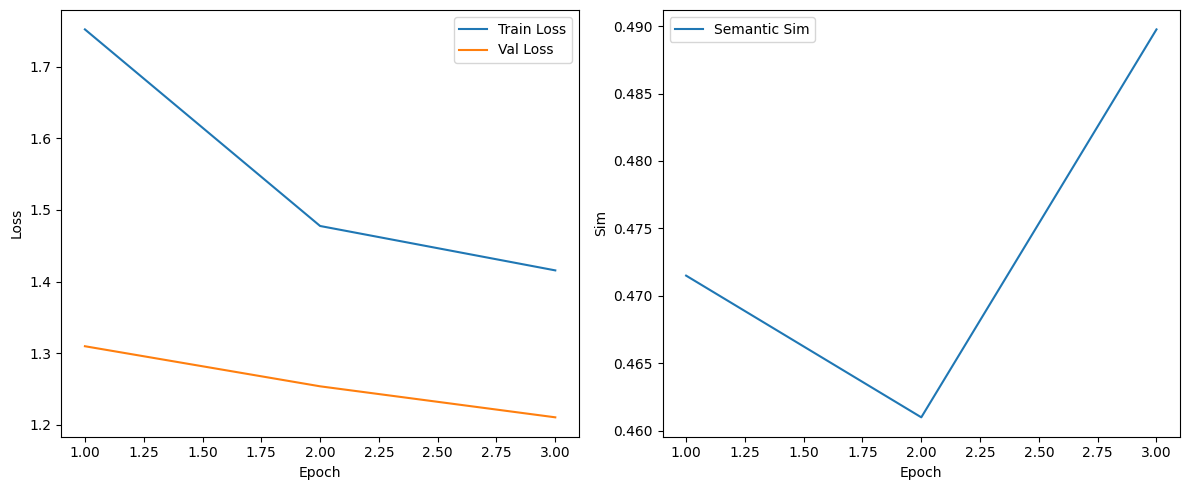


-- Phase 2, Epoch 1/2 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3923
  Validation Loss     : 1.2061
  Semantic Similarity : 0.4619

-- Phase 2, Epoch 2/2 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3805
  Validation Loss     : 1.2045
  Semantic Similarity : 0.4865


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 1.2245
Test Semantic Similarity: 0.4697

--- Example 147 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
slightly soft tissue swelling in medial portion of both 1st MTP joint area._x000D_
No bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
The patient has mild soft tissue swelling in the medial area of both first metatarsophalangeal joints.
Generated Report : 
FINDINGS: The patient has a degenerative change, requiring further evaluation. 

--- Example 172 ---
Raw Report       : 
[FINDING       ]_x000D_Diffuse osteopenia. 
Degenerative change, both feet. 
Both hallux valgus. 
Left naviculocuneiform coalition. _x000D__x000D_[CONCLUSION    ]_x000D_Diffuse osteopenia. 
Degenerative change, both feet. 
Both hallux valgus. 
Left naviculocuneiform coalition. _x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   : 
Diffuse osteopenia with degenerative changes in both feet and hallux valgus,

In [2]:
import os
import json
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# LoRA imports
from peft import LoraConfig, get_peft_model, TaskType

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (with mild geometric augmentations)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(
        degrees=10,              # ±10°
        translate=(0.1, 0.1),    # ±10%
        scale=(0.95, 1.05)       # 0.95–1.05×
    ),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.95, 1.05)
    ),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (using cleaned_report from JSON, _clean_report removed)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'raw_report': item.get('diagnosis', ''),
                'cleaned_report': item.get('cleaned_report', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('raw_report', '')
        clean = e.get('cleaned_report', '')

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    # _gen_patches unchanged
    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition, with LoRA integration (unchanged)
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        # Base GPT-2 decoder
        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

        # Apply LoRA to decoder
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=16,
            lora_alpha=32,
            lora_dropout=0.05,
            target_modules=["c_attn", "c_proj"],
            bias="none"
        )
        self.decoder = get_peft_model(self.decoder, lora_config)
        print("LoRA adapters integrated into GPT-2 decoder")

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p     = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled= self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (unchanged decode with FINDINGS:)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_  = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb    = model.norm(cat)

            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two-phase training with freeze/unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2_cleaned.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# instantiate model (with LoRA built in)
model = MultiModalModel().to(device)

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")
    print(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# =============================================================================
# Phase 1: freeze base GPT-2 and train only LoRA + vision adapters
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    p.requires_grad = False
# LoRA adapters remain trainable automatically
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True
for name, p in model.decoder.named_parameters():
    if "crossattention" in name.lower():
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 3
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze LoRA adapters only (keep base GPT-2 frozen)
# =============================================================================
for name, p in model.decoder.base_model.named_parameters():
    p.requires_grad = False

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 2
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # build visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


2025-05-20 19:17:41.455521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 19:17:41.462421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747793861.470106  175474 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747793861.472465  175474 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747793861.478529  175474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 01 → train_loss=1.0764, val_loss=0.7916, train_acc=0.0004, val_acc=0.0000


Epoch 02 → train_loss=0.7537, val_loss=0.7390, train_acc=0.0001, val_acc=0.0000


Epoch 03 → train_loss=0.6742, val_loss=0.7145, train_acc=0.0000, val_acc=0.0000


Epoch 04 → train_loss=0.6167, val_loss=0.7081, train_acc=0.0001, val_acc=0.0000


Epoch 05 → train_loss=0.5735, val_loss=0.7059, train_acc=0.0001, val_acc=0.0000


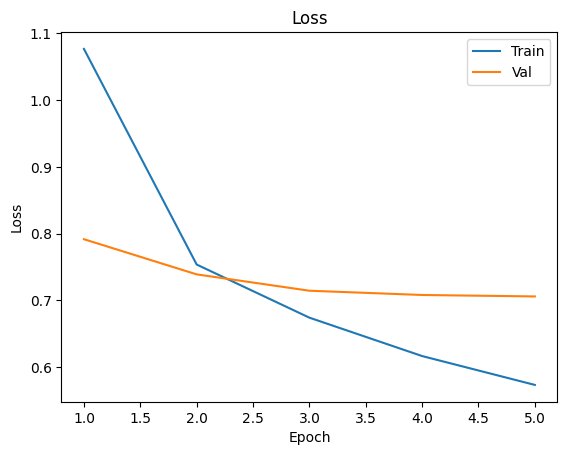

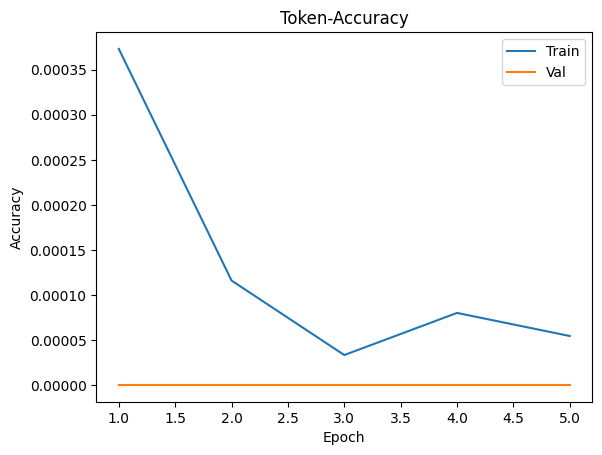


Three random examples:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Both the lateral aspect of the 1st metatarsophalangeal (MTP) joint shows osteophyte or ossification, and further evaluation is recommended.
Generated :  FINDINGS: The patient has diffuse osteopenia and degenerative changes, requiring ongoing management and potential treatment. 
Similarity: 0.4206


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient presents with diffuse joint space narrowing, erosions, flat foot, subluxation, and suspected inflammatory arthritis involving the wrist, hand, foot, and knee, likely involving Rheumatoid Arthritis.
Generated :  FINDINGS: The patient has diffuse osteopenia and subcortical cysts, suggesting a potential rheumatoid arthritis (RA) involvement. 
Similarity: 0.6815


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant bony lesion was found on radiographs; therefore, no further investigation is needed.
Generated :  FINDINGS: The patient has flat feet on both feet, exhibiting erosions at the first MTP joint, with no evidence of inflammatory arthritis, and therefore, no significant change in conclusion or recommendation. 
Similarity: 0.4252


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has osteopenia and degenerative changes due to a previous fracture in the left lateral malleolus.
Generated :  FINDINGS: The patient has advanced rheumatoid arthritis with bilateral hallux valgus in both knees and a bony erosions in both the left and right talus. 
Similarity: 0.3430


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has enthesopathy in both the calcaneus.
Generated :  FINDINGS: No bony lesion, no findings of concern, recommend further evaluation. 
Similarity: 0.3521


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant interval change has been observed since the last study.
Generated :  FINDINGS: No significant bony abnormality was found, and the recommendation is to monitor the condition. 
Similarity: 0.4224


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has osteopenia and narrowing of the third dorsal facet of the ankle, with joint space narrowing in the left third of the talus.
Generated :  FINDINGS: The patient presents with diffuse osteopenia, diffuse joint space narrowing, a calcaneous fracture, and soft tissue swelling in the left ankle, suggesting a possible gout condition. 
Similarity: 0.6420


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient exhibits degenerative changes, requiring further investigation and potential management.
Generated :  FINDINGS: The patient has R/O gout arthritis affecting both the first and second metatarsophalangeal joints (MTP) on both feet. 
Similarity: 0.2675


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Left tarsal joint rheumatoid arthritis (RA) is diagnosed with severe joint space narrowing and deformity.
Generated :  FINDINGS: Diffuse osteopenia and degenerative changes are present in both of the first MTP joints, requiring further investigation. 
Similarity: 0.4167


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony lesion, diagnosis: no bony lesion, recommended further evaluation.
Generated :  FINDINGS: The patient has a degenerative change. 
Similarity: 0.3725


In [1]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
import cv2
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None, patch_transform=None):
        self.tokenizer = tokenizer
        self.image_transform = image_transform or transforms.Compose([
            transforms.Resize((224,224)), transforms.ToTensor()
        ])
        self.patch_transform = patch_transform or transforms.Compose([
            transforms.Resize((112,112)), transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        filtered = []
        for item in raw:
            merged = item.get('merged_image_path','')
            fps = item.get('file_paths',[])
            if isinstance(fps,str): fps=[fps]
            paths = [merged] + fps
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged,fps,item))

        self.data = {}
        for i,(merged,fps,item) in enumerate(filtered):
            self.data[i] = {
                'full': merged,
                'patches': fps,
                'keypoints': item.get('keypoints',{}),
                'clean': item.get('cleaned_report','')
            }

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        e = self.data[idx]
        # full image
        img = Image.open(e['full']).convert('RGB')
        img = self.image_transform(img)
        # patches
        patches = self._gen_patches(e['patches'], e['keypoints'])
        pt = [ self.patch_transform(Image.fromarray(p)) for p in patches ]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)
        # tokenize
        prompt = f"{self.tokenizer.bos_token} FINDINGS: {e['clean']} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     e['clean']
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst=[]; pts=side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0)
                    y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1])
                    y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            p=paths[0]
            if os.path.exists(p):
                arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr,kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr,kps_dict['right'])
        else:
            for side,p in zip(['left','right'],paths):
                if p and os.path.exists(p):
                    arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst=extract(arr,kps_dict[side])
                        (left if side=='left' else right).extend(lst)

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left=[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])
        return pad17(left)+pad17(right)

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    patches   = torch.stack([b['patches']   for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'patches':         patches,
        'input_ids':       input_ids,
        'attention_mask':  attention_mask,
        'clean_text':      clean_txt
    }

# ----------------------------
# 2. Model
# ----------------------------
class VisionFusionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        self.global_enc  = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        self.global_proj = nn.Linear(self.global_enc.num_features, vision_dim)
        res = models.resnet50(pretrained=True); res.fc=nn.Identity()
        self.patch_enc   = res
        self.patch_proj  = nn.Linear(2048, vision_dim)
        self.cross_attn  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm        = nn.LayerNorm(vision_dim)

    def forward(self, full_img, patches):
        B = full_img.size(0)
        g = self.global_proj(self.global_enc(full_img))           # B×D
        P = patches.view(-1,3,112,112)
        p = self.patch_proj(self.patch_enc(P)).view(B,34,-1)      # B×34×D
        q,_ = self.cross_attn(g.unsqueeze(1), p, p)               # B×1×D
        fused = self.norm(q.squeeze(1) + g)                       # B×D
        return torch.cat([fused.unsqueeze(1), p], dim=1)          # B×35×D

class MedicalReportGenerator(nn.Module):
    def __init__(self, vision_dim=768, gpt2_model='gpt2', device='cuda'):
        super().__init__()
        self.device  = device
        self.encoder = VisionFusionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, patches, input_ids, attention_mask, labels=None):
        vt = self.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=self.device)
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels
        )

# ----------------------------
# 3. Training & Eval
# ----------------------------
def train_epoch(model, loader, optim, scheduler=None, epoch=0):
    model.train()
    tot_loss, tot_acc, n = 0,0,0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)

        optim.zero_grad()
        out = model(full, patches, ids, mask, labels=ids)
        loss = out.loss; loss.backward()
        optim.step()
        if scheduler: scheduler.step()

        preds = out.logits.argmax(-1)
        acc = (preds==ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item()*bsz
        tot_acc  += acc * bsz
        n += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss/n, tot_acc/n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    tot_loss, tot_acc, n = 0,0,0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)

        out = model(full, patches, ids, mask, labels=ids)
        loss = out.loss
        preds = out.logits.argmax(-1)
        acc = (preds==ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item()*bsz
        tot_acc  += acc * bsz
        n += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss/n, tot_acc/n

# ----------------------------
# 4. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(); plt.plot(epochs, train_losses);   plt.plot(epochs, val_losses)
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.show()
    plt.figure(); plt.plot(epochs, train_accs);   plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(['Train','Val']); plt.show()

# ----------------------------
# 5. Main
# ----------------------------
def main():
    logging.basicConfig(level=logging.INFO)
    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 5, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token':'<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # semantic embedder
    embedder = SentenceTransformer('all-MiniLM-L6-v2')

    # data & splits
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model = MedicalReportGenerator(device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    for ep in range(1, EPOCHS+1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader, epoch=ep)
        print(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l); val_losses.append(va_l)
        train_accs.append(tr_a);   val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # ----------------------------
    # 6. Test: sampling + overall similarity
    # ----------------------------
    model.eval()

    print("\nThree random examples:")
    examples = random.sample(range(len(te)), 10)
    for idx in examples:
        batch = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)

        emb = embedder.encode([gen, clean_txt])
        sim = cosine_similarity([emb[0]], [emb[1]])[0][0]

        print("—"*40)
        print("Clean     :", clean_txt)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")
'''
    # overall average
    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set"):
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb = embedder.encode([gen, clean_txt])
        #sims.append(cosine_similarity([emb[0]], [emb[1]])[0][0])

    overall = float(np.mean(sims))
    print(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")
'''
if __name__ == '__main__':
    main()


## With Augmentation

2025-05-21 20:28:16.286090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 20:28:16.292710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747884496.300275  189145 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747884496.302573  189145 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747884496.308613  189145 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 01 → train_loss=1.0969, val_loss=0.8169, train_acc=0.0004, val_acc=0.0000


Epoch 02 → train_loss=0.7561, val_loss=0.7498, train_acc=0.0001, val_acc=0.0000


Epoch 03 → train_loss=0.6786, val_loss=0.7221, train_acc=0.0000, val_acc=0.0000


Epoch 04 → train_loss=0.6201, val_loss=0.7081, train_acc=0.0001, val_acc=0.0000


Epoch 05 → train_loss=0.5740, val_loss=0.7036, train_acc=0.0001, val_acc=0.0000


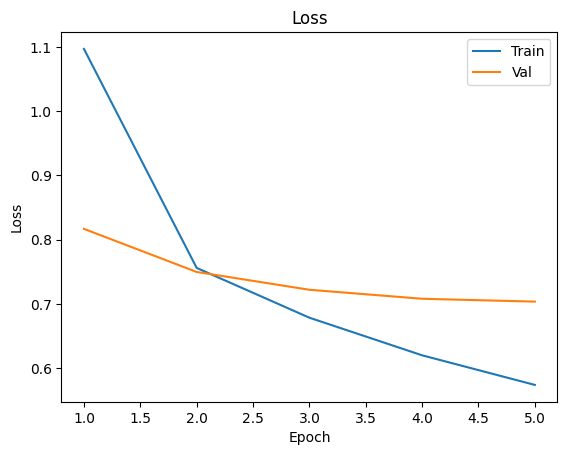

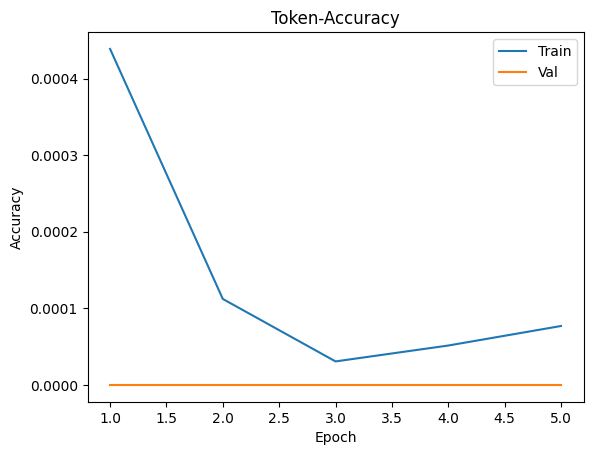


 20 random examples:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has findings of soft tissue swelling and loose body involvement in both the first MTP joint and ankle, requiring further investigation and potential treatment.
Generated :  FINDINGS: No significant bony lesion was identified on radiographs. 
Similarity: 0.3752


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change and recommends further investigation.
Generated :  FINDINGS: The patient has diffuse osteopenia due to degenerative changes, requiring further investigation and management. 
Similarity: 0.5333


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities are present, and no diagnosis is made.
Generated :  FINDINGS: Both MTP joint erosions are likely Rheumatoid Arthroarthritis. 
Similarity: 0.2152


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and degenerative change in both ankles, with both ankles exhibiting soft tissue swelling.
Generated :  FINDINGS: The patient has osteopenia and degenerative change, requiring further investigation and management. 
Similarity: 0.5973


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : There is no bony abnormality, and no diagnosis is currently recommended.
Generated :  FINDINGS: No significant bony lesion was identified on radiographs. 
Similarity: 0.7713


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant bony abnormality, therefore, no significant bony abnormality, no significant bony abnormality, and no recommendation.
Generated :  FINDINGS: No significant interval change, therefore, no significant interval change, and no specific recommendation is currently available. 
Similarity: 0.6008


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has soft tissue swelling in the first MTP joint of their right foot.
Generated :  FINDINGS: No significant bony abnormality, therefore, no significant bony abnormality, no significant bony abnormality, and no recommendations. 
Similarity: 0.2480


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, recommend further investigation.
Generated :  FINDINGS: No bony abnormality, resulting in no diagnosis of abnormality. 
Similarity: 0.8255


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient presents with suspicious gout lesions around the joints.
Generated :  FINDINGS: No significant bony abnormality was found, and no further investigation is recommended. 
Similarity: 0.3573


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, diagnosis: no abnormalities, recommend further evaluation.
Generated :  FINDINGS: No significant bony lesion was identified on radiographs. 
Similarity: 0.7831


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has evidence of gout involvement and enthesitis on the right ankle and talus, requiring further investigation.
Generated :  FINDINGS: The patient has a first metatarsophalangeal joint, type 2, with a possible navicular bone lesion, and soft tissue swelling. 
Similarity: 0.4284


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has joint space narrowing and erosions at both the first and fourth MT joints, suggesting a possible rheumatoid arthritis diagnosis and recommends further evaluation.
Generated :  FINDINGS: Diffuse osteopenia is a degenerative change requiring ongoing monitoring. 
Similarity: 0.3617


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities were found, and no further action is recommended.
Generated :  FINDINGS: No bony abnormality, therefore no need for further intervention. 
Similarity: 0.8712


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony lesions, with no findings of bony damage.
Generated :  FINDINGS: The report indicates a degenerative change requiring further investigation. 
Similarity: 0.3053


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a condition involving both the accessory navicular bones in both legs.
Generated :  FINDINGS: No bony lesion; diagnosis: no bony lesion. 
Similarity: 0.5216


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities were found, and no soft tissue abnormalities were observed.
Generated :  FINDINGS: Mild soft tissue swelling around the left first MTP joint, ruling out gout, and recommending further evaluation. 
Similarity: 0.2156


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change with a conclusion recommending further investigation and potential treatment.
Generated :  FINDINGS: The patient has degenerative changes and bone erosion of the first metatarsophalangeal joint, requiring ongoing management. 
Similarity: 0.5458


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities detected, suggesting no significant bony problem.
Generated :  FINDINGS: The patient has a diagnosis of degenerative changes of the ankle, with a history of old fracture and knee pain, requiring ongoing monitoring. 
Similarity: 0.3206


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a right accessory navicular bone type II with osteoarthritis.
Generated :  FINDINGS: The patient has soft tissue swelling and erosion in the left first metatarsophalangeal joint, requiring observation. 
Similarity: 0.4303


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and a history of a 2-4th finger amputation, requiring ongoing monitoring.
Generated :  FINDINGS: The report indicates a degenerative change with a conclusion recommending further investigation. 
Similarity: 0.2747


In [1]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
import cv2
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None, patch_transform=None):
        self.tokenizer = tokenizer
        # Default image transform with mild geometric augmentations
        self.image_transform = image_transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(
                degrees=10,             # ±10°
                translate=(0.1, 0.1),   # ±10% translation
                scale=(0.95, 1.05)      # 0.95×–1.05× scaling
            ),
            transforms.ToTensor()
        ])
        # Default patch transform with the same mild augmentations
        self.patch_transform = patch_transform or transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.95, 1.05)
            ),
            transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        filtered = []
        for item in raw:
            merged = item.get('merged_image_path','')
            fps = item.get('file_paths',[])
            if isinstance(fps,str): fps=[fps]
            paths = [merged] + fps
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged,fps,item))

        self.data = {}
        for i,(merged,fps,item) in enumerate(filtered):
            self.data[i] = {
                'full': merged,
                'patches': fps,
                'keypoints': item.get('keypoints',{}),
                'clean': item.get('cleaned_report','')
            }

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        e = self.data[idx]
        # full image
        img = Image.open(e['full']).convert('RGB')
        img = self.image_transform(img)
        # patches
        patches = self._gen_patches(e['patches'], e['keypoints'])
        pt = [ self.patch_transform(Image.fromarray(p)) for p in patches ]
        patches_tensor = torch.stack(pt,0) if pt else torch.zeros(34,3,112,112)
        # tokenize
        prompt = f"{self.tokenizer.bos_token} FINDINGS: {e['clean']} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     e['clean']
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst=[]; pts=side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0)
                    y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1])
                    y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            p=paths[0]
            if os.path.exists(p):
                arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr,kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr,kps_dict['right'])
        else:
            for side,p in zip(['left','right'],paths):
                if p and os.path.exists(p):
                    arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst=extract(arr,kps_dict[side])
                        (left if side=='left' else right).extend(lst)

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left=[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])
        return pad17(left)+pad17(right)

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    patches   = torch.stack([b['patches']   for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'patches':         patches,
        'input_ids':       input_ids,
        'attention_mask':  attention_mask,
        'clean_text':      clean_txt
    }

# ----------------------------
# 2. Model
# ----------------------------
class VisionFusionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        self.global_enc  = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        self.global_proj = nn.Linear(self.global_enc.num_features, vision_dim)
        res = models.resnet50(pretrained=True); res.fc=nn.Identity()
        self.patch_enc   = res
        self.patch_proj  = nn.Linear(2048, vision_dim)
        self.cross_attn  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm        = nn.LayerNorm(vision_dim)

    def forward(self, full_img, patches):
        B = full_img.size(0)
        g = self.global_proj(self.global_enc(full_img))           # B×D
        P = patches.view(-1,3,112,112)
        p = self.patch_proj(self.patch_enc(P)).view(B,34,-1)      # B×34×D
        q,_ = self.cross_attn(g.unsqueeze(1), p, p)               # B×1×D
        fused = self.norm(q.squeeze(1) + g)                       # B×D
        return torch.cat([fused.unsqueeze(1), p], dim=1)          # B×35×D

class MedicalReportGenerator(nn.Module):
    def __init__(self, vision_dim=768, gpt2_model='gpt2', device='cuda'):
        super().__init__()
        self.device  = device
        self.encoder = VisionFusionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, patches, input_ids, attention_mask, labels=None):
        vt = self.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=self.device)
        return self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels
        )

# ----------------------------
# 3. Training & Eval
# ----------------------------
def train_epoch(model, loader, optim, scheduler=None, epoch=0):
    model.train()
    tot_loss, tot_acc, n = 0,0,0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)

        optim.zero_grad()
        out = model(full, patches, ids, mask, labels=ids)
        loss = out.loss; loss.backward()
        optim.step()
        if scheduler: scheduler.step()

        preds = out.logits.argmax(-1)
        acc = (preds==ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item()*bsz
        tot_acc  += acc * bsz
        n += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss/n, tot_acc/n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    tot_loss, tot_acc, n = 0,0,0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)

        out = model(full, patches, ids, mask, labels=ids)
        loss = out.loss
        preds = out.logits.argmax(-1)
        acc = (preds==ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item()*bsz
        tot_acc  += acc * bsz
        n += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss/n, tot_acc/n

# ----------------------------
# 4. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(); plt.plot(epochs, train_losses);   plt.plot(epochs, val_losses)
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.show()
    plt.figure(); plt.plot(epochs, train_accs);   plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(['Train','Val']); plt.show()

# ----------------------------
# 5. Main
# ----------------------------
def main():
    logging.basicConfig(level=logging.INFO)
    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 5, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token':'<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # semantic embedder
    embedder = SentenceTransformer('all-MiniLM-L6-v2')

    # data & splits
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model = MedicalReportGenerator(device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    for ep in range(1, EPOCHS+1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader, epoch=ep)
        print(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l); val_losses.append(va_l)
        train_accs.append(tr_a);   val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # ----------------------------
    # 6. Test: sampling + overall similarity
    # ----------------------------
    model.eval()

    print("\n 20 random examples:")
    examples = random.sample(range(len(te)), 20)
    for idx in examples:
        batch = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)

        emb = embedder.encode([gen, clean_txt])
        sim = cosine_similarity([emb[0]], [emb[1]])[0][0]

        print("—"*40)
        print("Clean     :", clean_txt)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")
'''
    # overall average
    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set"):
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb = embedder.encode([gen, clean_txt])
        #sims.append(cosine_similarity([emb[0]], [emb[1]])[0][0])

    overall = float(np.mean(sims))
    print(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")
'''
if __name__ == '__main__':
    main()


## Multi Head Cross Attentions

In [6]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
import cv2
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None, patch_transform=None):
        self.tokenizer = tokenizer
        # Default image transform with mild geometric augmentations
        self.image_transform = image_transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(
                degrees=10,             # ±10°
                translate=(0.1, 0.1),   # ±10% translation
                scale=(0.95, 1.05)      # 0.95×–1.05× scaling
            ),
            transforms.ToTensor()
        ])
        # Default patch transform with the same mild augmentations
        self.patch_transform = patch_transform or transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.95, 1.05)
            ),
            transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        filtered = []
        for item in raw:
            merged = item.get('merged_image_path','')
            fps = item.get('file_paths',[])
            if isinstance(fps,str): fps=[fps]
            paths = [merged] + fps
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged,fps,item))

        self.data = {}
        for i,(merged,fps,item) in enumerate(filtered):
            self.data[i] = {
                'full': merged,
                'patches': fps,
                'keypoints': item.get('keypoints',{}),
                'clean': item.get('cleaned_report','')
            }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        # full image
        img = Image.open(e['full']).convert('RGB')
        img = self.image_transform(img)
        # patches
        patches = self._gen_patches(e['patches'], e['keypoints'])
        pt = [ self.patch_transform(Image.fromarray(p)) for p in patches ]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        # tokenize
        prompt = f"{self.tokenizer.bos_token} FINDINGS: {e['clean']} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     e['clean']
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst=[]; pts=side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0)
                    y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1])
                    y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            p=paths[0]
            if os.path.exists(p):
                arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr,kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr,kps_dict['right'])
        else:
            for side,p in zip(['left','right'],paths):
                if p and os.path.exists(p):
                    arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst=extract(arr,kps_dict[side])
                        (left if side=='left' else right).extend(lst)

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left=[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])
        return pad17(left)+pad17(right)

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    patches   = torch.stack([b['patches']   for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'patches':        patches,
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'clean_text':     clean_txt
    }

# ----------------------------
# 2. Model
# ----------------------------
class VisionFusionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        self.global_enc   = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        self.global_proj  = nn.Linear(self.global_enc.num_features, vision_dim)
        res = models.resnet50(pretrained=True); res.fc = nn.Identity()
        self.patch_enc    = res
        self.patch_proj   = nn.Linear(2048, vision_dim)
        # two cross-attention layers for deeper fusion
        self.cross_attn1  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm1        = nn.LayerNorm(vision_dim)
        self.cross_attn2  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm2        = nn.LayerNorm(vision_dim)

    def forward(self, full_img, patches):
        B = full_img.size(0)
        g = self.global_proj(self.global_enc(full_img))           # B×D
        P = patches.view(-1,3,112,112)
        p = self.patch_proj(self.patch_enc(P)).view(B,34,-1)      # B×34×D
        # first fusion
        q1, _ = self.cross_attn1(g.unsqueeze(1), p, p)            # B×1×D
        fused1 = self.norm1(q1.squeeze(1) + g)                     # B×D
        # second fusion
        q2, _ = self.cross_attn2(fused1.unsqueeze(1), p, p)       # B×1×D
        fused2 = self.norm2(q2.squeeze(1) + fused1)                # B×D
        return torch.cat([fused2.unsqueeze(1), p], dim=1)         # B×35×D

class MedicalReportGenerator(nn.Module):
    def __init__(self, tokenizer, vision_dim=768, gpt2_model='gpt2', device='cuda', sem_coef=0.1):
        super().__init__()
        self.device    = device
        self.tokenizer = tokenizer
        self.embedder  = SentenceTransformer('all-MiniLM-L6-v2')
        self.sem_coef  = sem_coef
        self.encoder   = VisionFusionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder   = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, patches, input_ids, attention_mask, clean_texts, labels=None):
        # encode vision
        vt = self.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=self.device)
        # decode with cross-attention
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels,
            return_dict=True
        )
        ce_loss = outputs.loss

        # semantic-aware loss
        with torch.no_grad():
            gen_ids = outputs.logits.argmax(-1)
            gen_texts = [ self.tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids ]
        emb_gen   = self.embedder.encode(gen_texts, convert_to_tensor=True, device=self.device)
        emb_truth = self.embedder.encode(clean_texts, convert_to_tensor=True, device=self.device)
        sims      = util.cos_sim(emb_gen, emb_truth)  # (batch, batch)
        sem_loss  = torch.mean(1.0 - sims.diag())

        loss = ce_loss + self.sem_coef * sem_loss
        return loss, outputs.logits

# ----------------------------
# 3. Training & Eval
# ----------------------------
def train_epoch(model, loader, optim, scheduler=None, epoch=0):
    model.train()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        optim.zero_grad()
        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        loss.backward()
        optim.step()
        if scheduler: scheduler.step()

        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

# ----------------------------
# 4. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(); plt.plot(epochs, train_losses);   plt.plot(epochs, val_losses)
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.show()
    plt.figure(); plt.plot(epochs, train_accs);   plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(['Train','Val']); plt.show()

# ----------------------------
# 5. Main
# ----------------------------
def main():
    logging.basicConfig(level=logging.INFO)
    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 1, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # data & splits
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model = MedicalReportGenerator(tokenizer, device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for ep in range(1, EPOCHS + 1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader, epoch=ep)
        print(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l)
        val_losses.append(va_l)
        train_accs.append(tr_a)
        val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # ----------------------------
    # 6. Test: sampling + overall similarity
    # ----------------------------
    model.eval()

    print("\n20 random examples:")
    examples = random.sample(range(len(te)), 20)
    for idx in examples:
        batch = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)

        emb = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sim = util.cos_sim(emb[0], emb[1]).item()

        print("—" * 40)
        print("Clean     :", clean_txt)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")

    # overall average
    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set"):
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb_pair = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sims.append(util.cos_sim(emb_pair[0], emb_pair[1]).item())

    overall = float(np.mean(sims))
    logging.info(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")

if __name__ == '__main__':
    main()


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_pr

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 1/240 [00:00<02:07,  1.88it/s, acc=0.00398, loss=6.77]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   1%|          | 2/240 [00:01<02:08,  1.85it/s, acc=0.0182, loss=4.55] 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   1%|▏         | 3/240 [00:01<02:05,  1.89it/s, acc=0.0186, loss=4.18]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   2%|▏         | 4/240 [00:02<02:03,  1.90it/s, acc=0.00613, loss=4.18]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   2%|▏         | 5/240 [00:02<02:06,  1.86it/s, acc=0, loss=2.65]      

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   2%|▎         | 6/240 [00:03<02:08,  1.83it/s, acc=0, loss=1.96]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   3%|▎         | 7/240 [00:03<02:07,  1.83it/s, acc=0, loss=1.77]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   3%|▎         | 8/240 [00:04<02:06,  1.83it/s, acc=0, loss=1.7] 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   4%|▍         | 9/240 [00:04<02:04,  1.85it/s, acc=0, loss=2.46]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   4%|▍         | 10/240 [00:05<02:02,  1.87it/s, acc=0, loss=1.35]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   5%|▍         | 11/240 [00:05<02:00,  1.90it/s, acc=0, loss=2.57]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   5%|▌         | 12/240 [00:06<02:00,  1.90it/s, acc=0.00413, loss=1.6]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   5%|▌         | 13/240 [00:06<01:59,  1.90it/s, acc=0, loss=1.53]     

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   6%|▌         | 14/240 [00:07<01:59,  1.88it/s, acc=0, loss=1.91]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   6%|▋         | 15/240 [00:08<02:00,  1.87it/s, acc=0, loss=1.4] 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   7%|▋         | 16/240 [00:08<01:58,  1.89it/s, acc=0, loss=1.45]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   7%|▋         | 17/240 [00:09<01:58,  1.88it/s, acc=0.00532, loss=1.51]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   8%|▊         | 18/240 [00:09<01:58,  1.87it/s, acc=0, loss=1.67]      

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   8%|▊         | 19/240 [00:10<01:57,  1.88it/s, acc=0, loss=1.51]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   8%|▊         | 20/240 [00:10<01:54,  1.92it/s, acc=0, loss=1.69]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   9%|▉         | 21/240 [00:11<01:54,  1.91it/s, acc=0, loss=1.25]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:   9%|▉         | 22/240 [00:11<01:55,  1.88it/s, acc=0, loss=1.54]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:  10%|▉         | 23/240 [00:12<01:55,  1.88it/s, acc=0, loss=1.26]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:  10%|█         | 24/240 [00:12<01:56,  1.86it/s, acc=0, loss=1.59]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:  10%|█         | 25/240 [00:13<01:55,  1.86it/s, acc=0, loss=1.65]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:  11%|█         | 26/240 [00:13<01:53,  1.89it/s, acc=0, loss=1.31]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:  11%|█▏        | 27/240 [00:14<01:51,  1.92it/s, acc=0, loss=1.61]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 [Train]:  12%|█▏        | 28/240 [00:14<01:50,  1.92it/s, acc=0, loss=1.23]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

2025-05-21 22:59:47,534 | INFO | Use pytorch device_name: cuda
2025-05-21 22:59:47,535 | INFO | Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-21 22:59:49,214 | INFO | Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
2025-05-21 22:59:49,300 | INFO | [timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight'

Epoch 01 → train_loss=1.1276, val_loss=0.8301, train_acc=0.0004, val_acc=0.0000


Epoch 02 → train_loss=0.7826, val_loss=0.7724, train_acc=0.0001, val_acc=0.0000


Epoch 03 → train_loss=0.7006, val_loss=0.7611, train_acc=0.0000, val_acc=0.0000


Epoch 04 → train_loss=0.6521, val_loss=0.7466, train_acc=0.0001, val_acc=0.0000


Epoch 05 → train_loss=0.6063, val_loss=0.7445, train_acc=0.0000, val_acc=0.0000


Epoch 06 → train_loss=0.5694, val_loss=0.7572, train_acc=0.0001, val_acc=0.0000


Epoch 07 → train_loss=0.5280, val_loss=0.7569, train_acc=0.0001, val_acc=0.0000


Epoch 08 → train_loss=0.4959, val_loss=0.7887, train_acc=0.0001, val_acc=0.0000


Epoch 09 → train_loss=0.4661, val_loss=0.7995, train_acc=0.0001, val_acc=0.0000


Epoch 10 → train_loss=0.4314, val_loss=0.8309, train_acc=0.0001, val_acc=0.0000


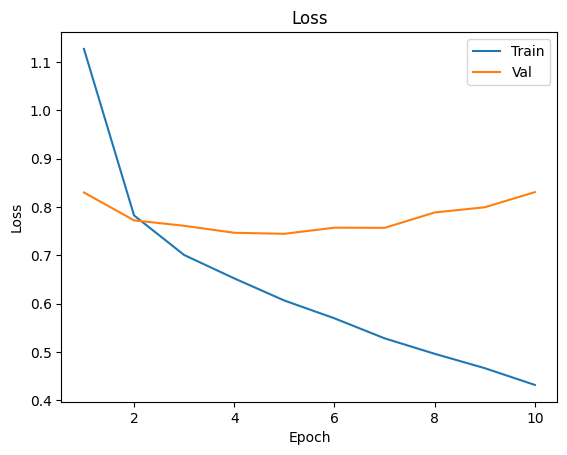

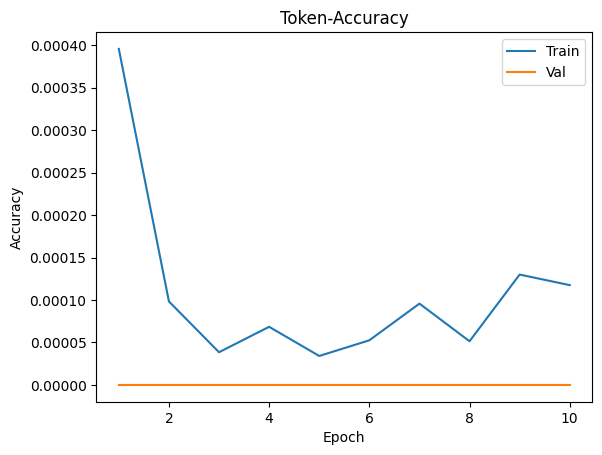


20 random examples:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a left foot presentation of a left hallux valgus and a right ankle post-op condition.
Generated :  FINDINGS: The patient has erosive changes in the 5th and 3rd metatarsophalangeal joints. 
Similarity: 0.4435


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant bony abnormality, resulting in no significant bony abnormality, and no significant bony abnormality.
Generated :  FINDINGS: No bony lesion; no findings of concern. 
Similarity: 0.7019


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia with a large os trigonum.
Generated :  FINDINGS: No bony abnormalities were identified, and no diagnosis was made. 
Similarity: 0.3825


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has advanced rheumatoid arthritis (RA) affecting both hands, feet, and the atlantoaxial joint with no instability, osteopenia, and no demonstrable instability.
Generated :  FINDINGS: Both 1st MTP joint erosions indicate rheumatoid arthritis. 
Similarity: 0.5556


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a compression fracture of the T12 vertebra with degenerative changes and osteopenia.
Generated :  FINDINGS: The patient has diffuse osteopenia and pes planus, requiring further management. 
Similarity: 0.4672


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Both feet appear to have a cavus foot, with no significant bony abnormalities detected on radiographs.
Generated :  FINDINGS: The patient has mild osteoarthritis and degenerative changes in the hallux valgus in both feet and hands, with a possible s/p PCLR diagnosis. 
Similarity: 0.4037


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : A diffuse vascular calcification pattern suggests a degenerative change of the left foot.
Generated :  FINDINGS: No bony abnormalities were found, and there is no evidence of a bony problem. 
Similarity: 0.2248


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and degenerative changes in both ankles and SI joints, with partial ankylosis, and treatment should focus on managing these conditions.
Generated :  FINDINGS: The patient has diffuse osteopenia and degenerative changes, requiring further evaluation and management. 
Similarity: 0.6614


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change, recommending further investigation and possible treatment.
Generated :  FINDINGS: A suspicious bone erosion is present on the left tributary. 
Similarity: 0.3073


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient experienced degenerative change following surgery.
Generated :  FINDINGS: The patient has an old fracture of the right radial malleolus, along with a small enthesophyte and osteophyte. 
Similarity: 0.3274


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, resulting in no diagnosis of abnormalities.
Generated :  FINDINGS: A small enthesophyte has been diagnosed in the plantar aspect of the right calcaneus and plantar area. 
Similarity: 0.2266


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : A suspicious inflammatory arthritis of the left 2nd MTP joint is recommended.
Generated :  FINDINGS: The patient has a diagnosis of hallux valgus on the left foot with a small entheses on both toes. 
Similarity: 0.3072


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, recommend further evaluation.
Generated :  FINDINGS: The patient presents with soft tissue swelling and loose body masses in the intertarsal joint, with joint space narrowing and loose body masses in the posterior portion of the left talus. 
Similarity: 0.5068


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has small osteophytes in both the first and calcaneus joints, and enthesophytes in the plantar aspect of the left calcaneus.
Generated :  FINDINGS: The report indicates a degenerative change requiring further investigation. 
Similarity: 0.2208


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change and recommends further evaluation.
Generated :  FINDINGS: The patient has degenerative changes affecting both of their toes and the talonavicular joint. 
Similarity: 0.5338


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities were found, and no further action is recommended.
Generated :  FINDINGS: The patient has two types of phalanges, potentially suggestive of osteoma. 
Similarity: 0.4203


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has soft tissue swelling in the left ankle with no bony erosion.
Generated :  FINDINGS: The patient has a bony erosion in both first metatarsophalangeal joints suggestive of gout. 
Similarity: 0.4660


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a degenerative change in both knees and wrists with narrowing and erosion, suggestive of cervical spondylosis, and likely involving disc narrowing and neural foraminal stenosis.
Generated :  FINDINGS: No bony lesion found, no recommendation is needed. 
Similarity: 0.3945


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has probable gouty arthritis in both metatarsophalangeal joints.
Generated :  FINDINGS: No bony lesion, diagnosis: no bony lesion. 
Similarity: 0.4162


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and degenerative changes.
Generated :  FINDINGS: The patient has a mild degenerative change diagnosed. 
Similarity: 0.5945


Evaluating test set:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   0%|          | 1/240 [00:00<00:25,  9.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   1%|          | 2/240 [00:00<00:33,  7.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   1%|▏         | 3/240 [00:00<00:31,  7.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▏         | 4/240 [00:00<00:41,  5.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▏         | 5/240 [00:00<00:41,  5.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▎         | 6/240 [00:00<00:38,  6.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   3%|▎         | 8/240 [00:01<00:34,  6.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   4%|▍         | 9/240 [00:01<00:31,  7.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   4%|▍         | 10/240 [00:01<00:31,  7.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▍         | 11/240 [00:01<00:31,  7.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▌         | 12/240 [00:01<00:30,  7.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▌         | 13/240 [00:01<00:30,  7.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   6%|▌         | 14/240 [00:02<00:36,  6.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   6%|▋         | 15/240 [00:02<00:34,  6.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 16/240 [00:02<00:32,  6.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 17/240 [00:02<00:29,  7.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 18/240 [00:02<00:31,  6.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 19/240 [00:02<00:32,  6.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 20/240 [00:02<00:30,  7.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   9%|▉         | 21/240 [00:02<00:28,  7.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   9%|▉         | 22/240 [00:03<00:29,  7.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|█         | 24/240 [00:03<00:24,  8.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|█         | 25/240 [00:03<00:24,  8.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  11%|█         | 26/240 [00:03<00:26,  7.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  11%|█▏        | 27/240 [00:03<00:26,  7.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▏        | 28/240 [00:03<00:27,  7.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▏        | 29/240 [00:03<00:26,  7.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▎        | 30/240 [00:04<00:26,  7.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  13%|█▎        | 31/240 [00:04<00:25,  8.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  13%|█▎        | 32/240 [00:04<00:24,  8.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  14%|█▍        | 34/240 [00:04<00:22,  9.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▍        | 35/240 [00:04<00:23,  8.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▌        | 36/240 [00:04<00:22,  9.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▌        | 37/240 [00:04<00:22,  8.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  16%|█▌        | 38/240 [00:04<00:22,  8.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  16%|█▋        | 39/240 [00:05<00:24,  8.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  17%|█▋        | 41/240 [00:05<00:22,  8.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 42/240 [00:05<00:22,  8.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 43/240 [00:05<00:22,  8.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 44/240 [00:05<00:21,  9.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  19%|█▉        | 45/240 [00:05<00:23,  8.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  19%|█▉        | 46/240 [00:05<00:23,  8.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|█▉        | 47/240 [00:06<00:23,  8.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|██        | 48/240 [00:06<00:27,  6.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|██        | 49/240 [00:06<00:26,  7.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  21%|██        | 50/240 [00:06<00:25,  7.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  21%|██▏       | 51/240 [00:06<00:24,  7.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▏       | 52/240 [00:06<00:23,  8.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▏       | 53/240 [00:06<00:22,  8.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▎       | 54/240 [00:06<00:22,  8.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  23%|██▎       | 55/240 [00:07<00:23,  7.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  23%|██▎       | 56/240 [00:07<00:25,  7.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  24%|██▍       | 57/240 [00:07<00:23,  7.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  24%|██▍       | 58/240 [00:07<00:22,  8.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▍       | 59/240 [00:07<00:22,  8.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▌       | 60/240 [00:07<00:22,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▌       | 61/240 [00:07<00:22,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  26%|██▌       | 62/240 [00:07<00:21,  8.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  26%|██▋       | 63/240 [00:08<00:21,  8.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  27%|██▋       | 64/240 [00:08<00:21,  8.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  27%|██▋       | 65/240 [00:08<00:21,  8.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 66/240 [00:08<00:21,  7.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 67/240 [00:08<00:20,  8.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 68/240 [00:08<00:19,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  29%|██▉       | 69/240 [00:08<00:19,  8.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|██▉       | 71/240 [00:09<00:19,  8.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|███       | 72/240 [00:09<00:19,  8.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|███       | 73/240 [00:09<00:20,  8.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  31%|███       | 74/240 [00:09<00:20,  8.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  31%|███▏      | 75/240 [00:09<00:19,  8.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▏      | 76/240 [00:09<00:20,  8.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▏      | 77/240 [00:09<00:25,  6.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  33%|███▎      | 79/240 [00:10<00:21,  7.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  33%|███▎      | 80/240 [00:10<00:21,  7.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  34%|███▍      | 81/240 [00:10<00:20,  7.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  34%|███▍      | 82/240 [00:10<00:20,  7.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▍      | 83/240 [00:10<00:19,  8.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▌      | 84/240 [00:10<00:18,  8.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▌      | 85/240 [00:10<00:18,  8.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  36%|███▌      | 86/240 [00:10<00:18,  8.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  36%|███▋      | 87/240 [00:11<00:17,  8.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  37%|███▋      | 88/240 [00:11<00:16,  8.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  37%|███▋      | 89/240 [00:11<00:16,  9.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 90/240 [00:11<00:16,  8.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 91/240 [00:11<00:16,  9.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  39%|███▉      | 93/240 [00:11<00:17,  8.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  39%|███▉      | 94/240 [00:11<00:17,  8.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|███▉      | 95/240 [00:11<00:16,  8.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|████      | 96/240 [00:12<00:17,  8.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  41%|████      | 98/240 [00:12<00:16,  8.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  41%|████▏     | 99/240 [00:12<00:16,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▏     | 100/240 [00:12<00:18,  7.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▏     | 101/240 [00:12<00:18,  7.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▎     | 102/240 [00:12<00:17,  7.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  43%|████▎     | 103/240 [00:12<00:16,  8.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  43%|████▎     | 104/240 [00:13<00:17,  7.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  44%|████▍     | 105/240 [00:13<00:17,  7.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  44%|████▍     | 106/240 [00:13<00:16,  7.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▍     | 107/240 [00:13<00:16,  8.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▌     | 108/240 [00:13<00:16,  8.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▌     | 109/240 [00:13<00:15,  8.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  46%|████▌     | 110/240 [00:13<00:16,  8.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  46%|████▋     | 111/240 [00:13<00:16,  7.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  47%|████▋     | 112/240 [00:14<00:16,  7.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  47%|████▋     | 113/240 [00:14<00:16,  7.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 114/240 [00:14<00:16,  7.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 115/240 [00:14<00:16,  7.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 116/240 [00:14<00:15,  7.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  49%|████▉     | 117/240 [00:14<00:17,  7.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  49%|████▉     | 118/240 [00:14<00:16,  7.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|████▉     | 119/240 [00:15<00:15,  7.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|█████     | 120/240 [00:15<00:14,  8.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|█████     | 121/240 [00:15<00:14,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  51%|█████     | 122/240 [00:15<00:13,  8.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  51%|█████▏    | 123/240 [00:15<00:14,  8.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▏    | 124/240 [00:15<00:13,  8.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▏    | 125/240 [00:15<00:13,  8.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▎    | 126/240 [00:15<00:13,  8.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  53%|█████▎    | 127/240 [00:16<00:15,  7.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  53%|█████▎    | 128/240 [00:16<00:16,  6.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  54%|█████▍    | 129/240 [00:16<00:16,  6.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  54%|█████▍    | 130/240 [00:16<00:15,  7.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▍    | 131/240 [00:16<00:16,  6.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▌    | 132/240 [00:16<00:15,  6.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▌    | 133/240 [00:16<00:14,  7.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  56%|█████▌    | 134/240 [00:17<00:15,  6.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  56%|█████▋    | 135/240 [00:17<00:14,  7.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▋    | 136/240 [00:17<00:14,  7.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▋    | 137/240 [00:17<00:13,  7.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▊    | 138/240 [00:17<00:15,  6.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  58%|█████▊    | 139/240 [00:17<00:15,  6.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  58%|█████▊    | 140/240 [00:17<00:15,  6.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  59%|█████▉    | 141/240 [00:18<00:14,  6.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  59%|█████▉    | 142/240 [00:18<00:13,  7.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|█████▉    | 143/240 [00:18<00:13,  7.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|██████    | 144/240 [00:18<00:12,  7.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|██████    | 145/240 [00:18<00:12,  7.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  61%|██████▏   | 147/240 [00:18<00:10,  8.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▏   | 148/240 [00:18<00:10,  8.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▏   | 149/240 [00:19<00:12,  7.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▎   | 150/240 [00:19<00:12,  7.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  63%|██████▎   | 151/240 [00:19<00:12,  7.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  63%|██████▎   | 152/240 [00:19<00:13,  6.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 153/240 [00:19<00:13,  6.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 154/240 [00:19<00:12,  6.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▍   | 155/240 [00:19<00:11,  7.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 156/240 [00:20<00:11,  7.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 157/240 [00:20<00:11,  7.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  66%|██████▌   | 158/240 [00:20<00:10,  7.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  66%|██████▋   | 159/240 [00:20<00:10,  7.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 160/240 [00:20<00:11,  7.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 161/240 [00:20<00:10,  7.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 162/240 [00:20<00:10,  7.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 163/240 [00:21<00:10,  7.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 164/240 [00:21<00:10,  7.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  69%|██████▉   | 165/240 [00:21<00:10,  7.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  69%|██████▉   | 166/240 [00:21<00:09,  7.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|██████▉   | 167/240 [00:21<00:10,  7.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|███████   | 168/240 [00:21<00:09,  7.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|███████   | 169/240 [00:21<00:09,  7.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  71%|███████   | 170/240 [00:21<00:09,  7.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  71%|███████▏  | 171/240 [00:22<00:08,  8.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▏  | 172/240 [00:22<00:08,  8.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▏  | 173/240 [00:22<00:08,  7.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▎  | 174/240 [00:22<00:08,  8.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  73%|███████▎  | 175/240 [00:22<00:07,  8.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  73%|███████▎  | 176/240 [00:22<00:08,  7.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  74%|███████▍  | 178/240 [00:22<00:07,  8.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▍  | 179/240 [00:23<00:06,  8.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▌  | 180/240 [00:23<00:06,  8.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▌  | 181/240 [00:23<00:06,  8.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  76%|███████▌  | 182/240 [00:23<00:06,  8.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  76%|███████▋  | 183/240 [00:23<00:06,  8.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  77%|███████▋  | 184/240 [00:23<00:06,  8.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  77%|███████▋  | 185/240 [00:23<00:06,  8.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 186/240 [00:23<00:06,  8.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 187/240 [00:23<00:06,  8.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 188/240 [00:24<00:06,  8.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  79%|███████▉  | 189/240 [00:24<00:06,  7.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  79%|███████▉  | 190/240 [00:24<00:06,  7.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|███████▉  | 191/240 [00:24<00:05,  8.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|████████  | 192/240 [00:24<00:05,  8.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|████████  | 193/240 [00:24<00:05,  7.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  81%|████████  | 194/240 [00:24<00:06,  6.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  81%|████████▏ | 195/240 [00:25<00:06,  7.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▏ | 196/240 [00:25<00:05,  7.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▏ | 197/240 [00:25<00:05,  7.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▎ | 198/240 [00:25<00:05,  8.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  83%|████████▎ | 199/240 [00:25<00:04,  8.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  83%|████████▎ | 200/240 [00:25<00:04,  8.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  84%|████████▍ | 201/240 [00:25<00:04,  8.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  84%|████████▍ | 202/240 [00:25<00:04,  7.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▍ | 203/240 [00:25<00:04,  8.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▌ | 204/240 [00:26<00:04,  8.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▌ | 205/240 [00:26<00:04,  8.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  86%|████████▌ | 206/240 [00:26<00:03,  8.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  86%|████████▋ | 207/240 [00:26<00:03,  8.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  87%|████████▋ | 208/240 [00:26<00:04,  6.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 210/240 [00:26<00:04,  7.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 211/240 [00:27<00:03,  7.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 212/240 [00:27<00:03,  7.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  89%|████████▉ | 213/240 [00:27<00:03,  7.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  89%|████████▉ | 214/240 [00:27<00:03,  8.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|████████▉ | 215/240 [00:27<00:03,  8.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|█████████ | 216/240 [00:27<00:03,  6.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  91%|█████████ | 218/240 [00:27<00:02,  7.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  91%|█████████▏| 219/240 [00:28<00:02,  7.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▏| 220/240 [00:28<00:02,  7.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▏| 221/240 [00:28<00:02,  8.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▎| 222/240 [00:28<00:02,  7.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  93%|█████████▎| 223/240 [00:28<00:02,  6.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  93%|█████████▎| 224/240 [00:28<00:02,  7.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  94%|█████████▍| 225/240 [00:28<00:02,  6.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  94%|█████████▍| 226/240 [00:29<00:01,  7.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▍| 227/240 [00:29<00:01,  7.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▌| 228/240 [00:29<00:01,  7.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▌| 229/240 [00:29<00:01,  8.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  96%|█████████▌| 230/240 [00:29<00:01,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  96%|█████████▋| 231/240 [00:29<00:01,  7.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  97%|█████████▋| 232/240 [00:29<00:00,  8.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  97%|█████████▋| 233/240 [00:29<00:00,  7.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 234/240 [00:30<00:00,  8.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 235/240 [00:30<00:00,  8.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 236/240 [00:30<00:00,  6.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  99%|█████████▉| 237/240 [00:30<00:00,  6.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  99%|█████████▉| 238/240 [00:30<00:00,  6.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|█████████▉| 239/240 [00:30<00:00,  6.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|██████████| 240/240 [00:30<00:00,  7.76it/s]
2025-05-21 23:23:31,699 | INFO | 
Average semantic similarity over 240 test samples: 0.4512


In [2]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
import cv2
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None, patch_transform=None):
        self.tokenizer = tokenizer
        # Default image transform with mild geometric augmentations
        self.image_transform = image_transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(
                degrees=10,             # ±10°
                translate=(0.1, 0.1),   # ±10% translation
                scale=(0.95, 1.05)      # 0.95×–1.05× scaling
            ),
            transforms.ToTensor()
        ])
        # Default patch transform with the same mild augmentations
        self.patch_transform = patch_transform or transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.95, 1.05)
            ),
            transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        filtered = []
        for item in raw:
            merged = item.get('merged_image_path','')
            fps = item.get('file_paths',[])
            if isinstance(fps,str): fps=[fps]
            paths = [merged] + fps
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged,fps,item))

        self.data = {}
        for i,(merged,fps,item) in enumerate(filtered):
            self.data[i] = {
                'full': merged,
                'patches': fps,
                'keypoints': item.get('keypoints',{}),
                'clean': item.get('cleaned_report','')
            }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        # full image
        img = Image.open(e['full']).convert('RGB')
        img = self.image_transform(img)
        # patches
        patches = self._gen_patches(e['patches'], e['keypoints'])
        pt = [ self.patch_transform(Image.fromarray(p)) for p in patches ]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        # tokenize
        prompt = f"{self.tokenizer.bos_token} FINDINGS: {e['clean']} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     e['clean']
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst=[]; pts=side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0)
                    y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1])
                    y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            p=paths[0]
            if os.path.exists(p):
                arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr,kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr,kps_dict['right'])
        else:
            for side,p in zip(['left','right'],paths):
                if p and os.path.exists(p):
                    arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst=extract(arr,kps_dict[side])
                        (left if side=='left' else right).extend(lst)

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left=[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])
        return pad17(left)+pad17(right)

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    patches   = torch.stack([b['patches']   for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'patches':        patches,
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'clean_text':     clean_txt
    }

# ----------------------------
# 2. Model
# ----------------------------
class VisionFusionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        self.global_enc   = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        self.global_proj  = nn.Linear(self.global_enc.num_features, vision_dim)
        res = models.resnet50(pretrained=True); res.fc = nn.Identity()
        self.patch_enc    = res
        self.patch_proj   = nn.Linear(2048, vision_dim)
        # two cross-attention layers for deeper fusion
        self.cross_attn1  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm1        = nn.LayerNorm(vision_dim)
        self.cross_attn2  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm2        = nn.LayerNorm(vision_dim)

    def forward(self, full_img, patches):
        B = full_img.size(0)
        g = self.global_proj(self.global_enc(full_img))           # B×D
        P = patches.view(-1,3,112,112)
        p = self.patch_proj(self.patch_enc(P)).view(B,34,-1)      # B×34×D
        # first fusion
        q1, _ = self.cross_attn1(g.unsqueeze(1), p, p)            # B×1×D
        fused1 = self.norm1(q1.squeeze(1) + g)                     # B×D
        # second fusion
        q2, _ = self.cross_attn2(fused1.unsqueeze(1), p, p)       # B×1×D
        fused2 = self.norm2(q2.squeeze(1) + fused1)                # B×D
        return torch.cat([fused2.unsqueeze(1), p], dim=1)         # B×35×D

class MedicalReportGenerator(nn.Module):
    def __init__(self, tokenizer, vision_dim=768, gpt2_model='gpt2', device='cuda', sem_coef=0.1):
        super().__init__()
        self.device    = device
        self.tokenizer = tokenizer
        self.embedder  = SentenceTransformer('all-MiniLM-L6-v2')
        self.sem_coef  = sem_coef
        self.encoder   = VisionFusionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder   = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, patches, input_ids, attention_mask, clean_texts, labels=None):
        # encode vision
        vt = self.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=self.device)
        # decode with cross-attention
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels,
            return_dict=True
        )
        ce_loss = outputs.loss

        # semantic-aware loss
        with torch.no_grad():
            gen_ids = outputs.logits.argmax(-1)
            gen_texts = [ self.tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids ]
            emb_gen   = self.embedder.encode(
                gen_texts,
                convert_to_tensor=True,
                device=self.device,
                show_progress_bar=False
            )
            emb_truth = self.embedder.encode(
                clean_texts,
                convert_to_tensor=True,
                device=self.device,
                show_progress_bar=False
            )
        sims      = util.cos_sim(emb_gen, emb_truth)  # (batch, batch)
        sem_loss  = torch.mean(1.0 - sims.diag())

        loss = ce_loss + self.sem_coef * sem_loss
        return loss, outputs.logits

# ----------------------------
# 3. Training & Eval
# ----------------------------
def train_epoch(model, loader, optim, scheduler=None, epoch=0):
    model.train()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        optim.zero_grad()
        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        loss.backward()
        optim.step()
        if scheduler: scheduler.step()

        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

# ----------------------------
# 4. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(); plt.plot(epochs, train_losses);   plt.plot(epochs, val_losses)
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.show()
    plt.figure(); plt.plot(epochs, train_accs);   plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(['Train','Val']); plt.show()

# ----------------------------
# 5. Main
# ----------------------------
def main():
    logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    handlers=[
        logging.FileHandler("training.log"),
        logging.StreamHandler()
    ]
)
    logging.basicConfig(level=logging.INFO)
    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 10, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # data & splits
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model = MedicalReportGenerator(tokenizer, device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for ep in range(1, EPOCHS + 1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader, epoch=ep)
        print(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l)
        val_losses.append(va_l)
        train_accs.append(tr_a)
        val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # ----------------------------
    # 6. Test: sampling + overall similarity
    # ----------------------------
    model.eval()

    print("\n20 random examples:")
    examples = random.sample(range(len(te)), 20)
    for idx in examples:
        batch = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)

        emb = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sim = util.cos_sim(emb[0], emb[1]).item()

        print("—" * 40)
        print("Clean     :", clean_txt)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")

    # overall average
    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set"):
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb_pair = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sims.append(util.cos_sim(emb_pair[0], emb_pair[1]).item())

    overall = float(np.mean(sims))
    logging.info(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")

if __name__ == '__main__':
    main()


## Only Raw Image Encoder 

2025-05-22 11:41:41,652 | INFO | Use pytorch device_name: cuda
2025-05-22 11:41:41,652 | INFO | Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-22 11:41:43,151 | INFO | Loading pretrained weights from Hugging Face hub (timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k)
2025-05-22 11:41:43,243 | INFO | [timm/swin_base_patch4_window7_224.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight'

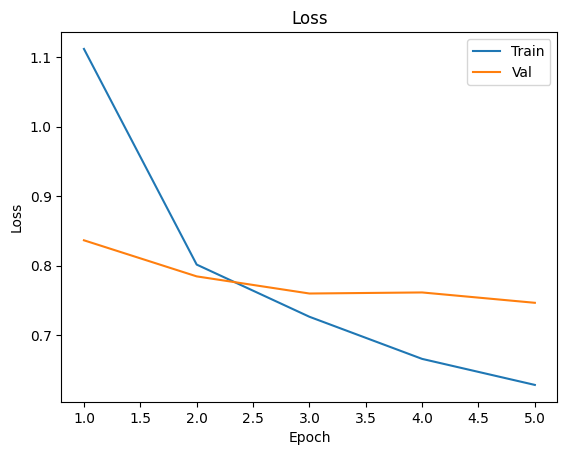

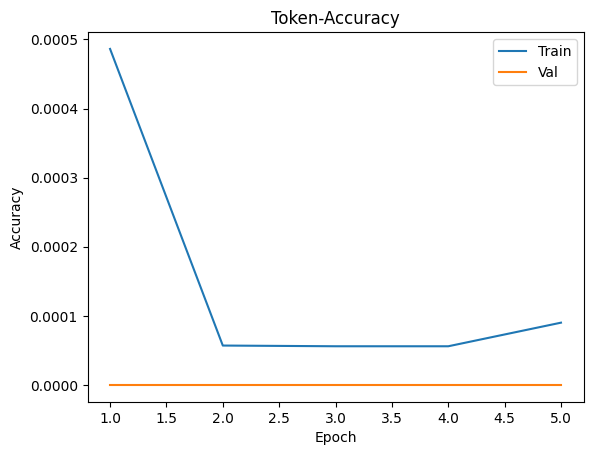


20 random examples:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : A suspicious juxta-articular bone erosion in the left lateral malleola region is suggested, requiring further investigation.
Generated :  FINDINGS: Diffuse osteopenia is a degenerative change, requiring ongoing monitoring. 
Similarity: 0.4054


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has pes planus on both feet.
Generated :  FINDINGS: No bony lesion, diagnosis: No bony lesion, recommend further investigation. 
Similarity: 0.3294


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a subtle fracture with a suspicious old fracture and soft tissue swelling in the right ankle.
Generated :  FINDINGS: The patient has a diagnosed with periarticular osteopenia. 
Similarity: 0.4194


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change requiring further investigation and management.
Generated :  FINDINGS: The report indicates a degenerative change, suggesting a condition requiring further investigation and potential treatment. 
Similarity: 0.8893


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Subtle bone erosion at the right first prefrontal operculum (RT-1st PP) without tophi, requiring no further treatment, suggests gout arthritis.
Generated :  FINDINGS: No significant interval change, therefore, no significant interval change, and no further recommendations are recommended. 
Similarity: 0.1472


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has joint space narrowing and erosions at both the first and fourth MT joints, suggesting a possible rheumatoid arthritis diagnosis and recommends further evaluation.
Generated :  FINDINGS: Both feet exhibit degenerative changes. 
Similarity: 0.3722


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has suspicious erosions at the right first metatarsophalangeal joint and degenerative changes.
Generated :  FINDINGS: The patient has degenerative changes in both ankles. 
Similarity: 0.5234


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change, suggesting a condition requiring further investigation and treatment.
Generated :  FINDINGS: No significant bony lesion was detected on radiographs. 
Similarity: 0.2857


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has an inflammatory arthritis diagnosis.
Generated :  FINDINGS: The report indicates a degenerative change with a conclusion recommending further investigation. 
Similarity: 0.2701


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant change has been observed in the patient’s condition since the last study.
Generated :  FINDINGS: No significant bony lesion was found on radiographs, therefore, no significant bony lesion is recommended. 
Similarity: 0.5388


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant bony lesion was found on radiographs, and no recommendations are needed.
Generated :  FINDINGS: No bony abnormality, diagnosis: No abnormality, recommend further evaluation. 
Similarity: 0.7223


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, therefore no abnormalities were detected.
Generated :  FINDINGS: Diffuse osteopenia and degenerative changes in both knees require further investigation and management. 
Similarity: 0.2387


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a right accessory navicular bone type III and a left accessory navicular bone type II.
Generated :  FINDINGS: The patient has severe osteoarthritis and calcification in both knees and ankles, requiring further evaluation and potential treatment. 
Similarity: 0.3157


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has hallux valgus on both feet, small osteophytes and entheses in the first and calcaneus joints, small calcifications in the ankle posterior region, and soft tissue swelling of the ankle.
Generated :  FINDINGS: The patient has soft tissue swelling in the right fifth toe, a small fracture in the right first proximal phalanx, and suspected inflammatory arthritis in the right talonavicular joint. 
Similarity: 0.5984


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a diagnosis of hallux vagus deformity and diffuse osteopenia.
Generated :  FINDINGS: The patient presents with moderate osteoarthritis in both knees, both ankles, hands, knees, wrists, and wrists, with subchondral cysts in the left 4th proximal phalanx, both accessory navicular bones, and calcaneal enthesophytes in both knees and ankles. 
Similarity: 0.3806


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has soft tissue swelling in the left ankle with no bony erosion.
Generated :  FINDINGS: The patient has both knees with osteoarthritis in both knees, with suspicious erosion and calcification in the right medial and lateral joints. 
Similarity: 0.4945


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has minimal osteoarthritis in both knees and both toes.
Generated :  FINDINGS: The patient has a suspicious lack of bone abnormalities in both knees, requiring further investigation and management. 
Similarity: 0.6597


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient presents with joint pain and inflammation in the right knee and ankle, with diagnoses of gout arthritis and post-operative conditions in both joints.
Generated :  FINDINGS: The patient has a diagnosis of both ankles and knee with degenerative changes. 
Similarity: 0.5878


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has soft tissue swelling in the left first metatarsophalangeal joint (1st MTP) and an enthesophyte in the right calcaneus.
Generated :  FINDINGS: The patient has suspicious calcaneous and enthesophytes in the right calcaneous shaft, consistent with gout. 
Similarity: 0.6037


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has an old avulsion with healing, presenting with a bony protrusion on both feet with no significant bony lesion on radiographs.
Generated :  FINDINGS: The patient has soft tissue swelling and erosions at the Lt. 1st MTP joint, suggesting possible rheumatoid arthritis involvement. 
Similarity: 0.4053


Evaluating test set:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   1%|          | 2/240 [00:00<00:26,  9.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▏         | 4/240 [00:00<00:24,  9.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▎         | 6/240 [00:00<00:23, 10.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   3%|▎         | 8/240 [00:00<00:21, 10.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   4%|▍         | 10/240 [00:01<00:25,  9.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▍         | 11/240 [00:01<00:26,  8.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▌         | 12/240 [00:01<00:29,  7.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▌         | 13/240 [00:01<00:31,  7.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   6%|▌         | 14/240 [00:01<00:30,  7.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   6%|▋         | 15/240 [00:01<00:29,  7.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 16/240 [00:01<00:33,  6.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 17/240 [00:02<00:30,  7.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 18/240 [00:02<00:28,  7.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 20/240 [00:02<00:25,  8.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   9%|▉         | 21/240 [00:02<00:25,  8.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|▉         | 23/240 [00:02<00:23,  9.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|█         | 25/240 [00:02<00:22,  9.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  11%|█         | 26/240 [00:03<00:22,  9.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  11%|█▏        | 27/240 [00:03<00:22,  9.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▏        | 28/240 [00:03<00:27,  7.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▎        | 30/240 [00:03<00:25,  8.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  13%|█▎        | 31/240 [00:03<00:24,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  14%|█▍        | 33/240 [00:03<00:23,  8.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  14%|█▍        | 34/240 [00:03<00:23,  8.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▍        | 35/240 [00:04<00:22,  9.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▌        | 37/240 [00:04<00:23,  8.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  16%|█▌        | 38/240 [00:04<00:22,  8.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  16%|█▋        | 39/240 [00:04<00:22,  8.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  17%|█▋        | 41/240 [00:04<00:20,  9.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 42/240 [00:04<00:20,  9.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 43/240 [00:05<00:35,  5.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  19%|█▉        | 45/240 [00:05<00:28,  6.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|█▉        | 47/240 [00:05<00:23,  8.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|██        | 48/240 [00:05<00:24,  7.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  21%|██        | 50/240 [00:05<00:21,  8.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▏       | 52/240 [00:06<00:19,  9.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▎       | 54/240 [00:06<00:18,  9.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  23%|██▎       | 56/240 [00:06<00:20,  9.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  24%|██▍       | 58/240 [00:06<00:18,  9.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▌       | 60/240 [00:06<00:18,  9.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  26%|██▌       | 62/240 [00:07<00:17, 10.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  27%|██▋       | 64/240 [00:07<00:18,  9.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 66/240 [00:07<00:18,  9.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 67/240 [00:07<00:18,  9.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  29%|██▉       | 69/240 [00:07<00:17,  9.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  29%|██▉       | 70/240 [00:07<00:17,  9.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|██▉       | 71/240 [00:08<00:23,  7.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|███       | 72/240 [00:08<00:24,  6.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|███       | 73/240 [00:08<00:23,  6.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  31%|███▏      | 75/240 [00:08<00:20,  8.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▏      | 77/240 [00:08<00:19,  8.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  33%|███▎      | 79/240 [00:09<00:16,  9.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  34%|███▍      | 81/240 [00:09<00:16,  9.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  34%|███▍      | 82/240 [00:09<00:17,  8.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▍      | 83/240 [00:09<00:17,  8.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▌      | 85/240 [00:09<00:17,  9.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  36%|███▋      | 87/240 [00:09<00:15,  9.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  37%|███▋      | 89/240 [00:10<00:15,  9.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 90/240 [00:10<00:15,  9.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 92/240 [00:10<00:15,  9.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  39%|███▉      | 93/240 [00:10<00:17,  8.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|███▉      | 95/240 [00:10<00:15,  9.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|████      | 96/240 [00:10<00:15,  9.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|████      | 97/240 [00:11<00:15,  9.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  41%|████▏     | 99/240 [00:11<00:14,  9.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▏     | 100/240 [00:11<00:14,  9.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▎     | 102/240 [00:11<00:13,  9.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  43%|████▎     | 104/240 [00:11<00:13, 10.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  44%|████▍     | 106/240 [00:11<00:14,  8.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▍     | 107/240 [00:12<00:14,  9.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▌     | 108/240 [00:12<00:14,  9.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▌     | 109/240 [00:12<00:14,  9.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  46%|████▌     | 110/240 [00:12<00:14,  9.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  47%|████▋     | 112/240 [00:12<00:14,  8.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  47%|████▋     | 113/240 [00:12<00:14,  8.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 114/240 [00:12<00:13,  9.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 115/240 [00:12<00:13,  9.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  49%|████▉     | 117/240 [00:13<00:12,  9.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  49%|████▉     | 118/240 [00:13<00:12,  9.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|█████     | 120/240 [00:13<00:14,  8.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  51%|█████     | 122/240 [00:13<00:13,  8.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▏    | 124/240 [00:13<00:11,  9.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▎    | 126/240 [00:14<00:11,  9.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  53%|█████▎    | 128/240 [00:14<00:11,  9.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  54%|█████▍    | 130/240 [00:14<00:11,  9.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▍    | 131/240 [00:14<00:11,  9.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▌    | 132/240 [00:14<00:11,  9.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  56%|█████▌    | 134/240 [00:14<00:11,  9.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  56%|█████▋    | 135/240 [00:15<00:12,  8.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▋    | 136/240 [00:15<00:11,  8.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▊    | 138/240 [00:15<00:10,  9.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  58%|█████▊    | 140/240 [00:15<00:10,  9.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  59%|█████▉    | 141/240 [00:15<00:12,  8.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  59%|█████▉    | 142/240 [00:15<00:13,  7.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|█████▉    | 143/240 [00:16<00:13,  6.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|██████    | 144/240 [00:16<00:13,  6.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  61%|██████    | 146/240 [00:16<00:11,  8.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  61%|██████▏   | 147/240 [00:16<00:11,  8.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▏   | 148/240 [00:16<00:11,  7.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▎   | 150/240 [00:16<00:10,  8.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  63%|██████▎   | 151/240 [00:17<00:10,  8.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 153/240 [00:17<00:09,  8.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 154/240 [00:17<00:09,  8.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 156/240 [00:17<00:08,  9.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 157/240 [00:17<00:08,  9.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  66%|██████▌   | 158/240 [00:17<00:08,  9.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 160/240 [00:17<00:08,  9.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 161/240 [00:18<00:08,  9.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 163/240 [00:18<00:07,  9.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 164/240 [00:18<00:07,  9.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  69%|██████▉   | 165/240 [00:18<00:07,  9.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  69%|██████▉   | 166/240 [00:18<00:07,  9.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|██████▉   | 167/240 [00:18<00:07,  9.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|███████   | 168/240 [00:18<00:07,  9.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|███████   | 169/240 [00:18<00:07,  9.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  71%|███████▏  | 171/240 [00:19<00:07,  9.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▏  | 173/240 [00:19<00:06,  9.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▎  | 174/240 [00:19<00:06,  9.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  73%|███████▎  | 175/240 [00:19<00:07,  9.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  74%|███████▍  | 177/240 [00:19<00:06,  9.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▍  | 179/240 [00:20<00:06,  9.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▌  | 180/240 [00:20<00:06,  9.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  76%|███████▌  | 182/240 [00:20<00:06,  9.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  76%|███████▋  | 183/240 [00:20<00:06,  9.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  77%|███████▋  | 185/240 [00:20<00:05,  9.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 186/240 [00:20<00:05,  9.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 188/240 [00:20<00:05,  9.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  79%|███████▉  | 189/240 [00:21<00:05,  8.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|███████▉  | 191/240 [00:21<00:05,  9.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|████████  | 192/240 [00:21<00:05,  9.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|████████  | 193/240 [00:21<00:05,  8.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  81%|████████  | 194/240 [00:21<00:05,  7.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  81%|████████▏ | 195/240 [00:21<00:05,  8.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▏ | 197/240 [00:21<00:04,  9.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▎ | 198/240 [00:22<00:04,  9.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  83%|████████▎ | 200/240 [00:22<00:04,  9.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  84%|████████▍ | 201/240 [00:22<00:05,  7.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  84%|████████▍ | 202/240 [00:22<00:05,  6.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▌ | 204/240 [00:22<00:04,  8.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  86%|████████▌ | 206/240 [00:23<00:03,  8.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  86%|████████▋ | 207/240 [00:23<00:04,  8.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  87%|████████▋ | 208/240 [00:23<00:03,  8.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 210/240 [00:23<00:03,  9.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 211/240 [00:23<00:03,  8.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 212/240 [00:23<00:03,  9.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  89%|████████▉ | 214/240 [00:24<00:02,  9.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|█████████ | 216/240 [00:24<00:02,  9.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|█████████ | 217/240 [00:24<00:02,  9.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  91%|█████████▏| 219/240 [00:24<00:02,  9.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▏| 220/240 [00:24<00:02,  9.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▏| 221/240 [00:24<00:02,  9.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▎| 222/240 [00:24<00:02,  8.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  93%|█████████▎| 223/240 [00:24<00:01,  8.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  93%|█████████▎| 224/240 [00:25<00:01,  8.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  94%|█████████▍| 226/240 [00:25<00:01,  9.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▍| 227/240 [00:25<00:01,  9.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▌| 229/240 [00:25<00:01,  9.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  96%|█████████▌| 230/240 [00:25<00:01,  9.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  96%|█████████▋| 231/240 [00:25<00:00,  9.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  97%|█████████▋| 233/240 [00:26<00:00,  9.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 235/240 [00:26<00:00, 10.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  99%|█████████▉| 237/240 [00:26<00:00, 10.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|█████████▉| 239/240 [00:26<00:00, 10.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|██████████| 240/240 [00:26<00:00,  8.99it/s]
2025-05-22 11:48:09,503 | INFO | 
Average semantic similarity over 240 test samples: 0.4137


In [2]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None):
        self.tokenizer = tokenizer
        self.image_transform = image_transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.95, 1.05)
            ),
            transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        items = []
        for item in raw:
            path = item.get('merged_image_path', '')
            if os.path.exists(path):
                items.append((path, item.get('cleaned_report', '')))

        self.data = items

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, clean_text = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.image_transform(img)

        prompt = f"{self.tokenizer.bos_token} FINDINGS: {clean_text} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     clean_text
        }

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'clean_text':     clean_txt
    }

# ----------------------------
# 2. Vision Encoder w/ 4× Cross-Attention
# ----------------------------
class VisionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        # pretrained Swin → raw features
        self.global_enc  = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        self.global_proj = nn.Linear(self.global_enc.num_features, vision_dim)
        # four stacked “cross-attention” layers (here self-attending the single token)
        self.cross_attn1 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm1       = nn.LayerNorm(vision_dim)
        self.cross_attn2 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm2       = nn.LayerNorm(vision_dim)
        self.cross_attn3 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm3       = nn.LayerNorm(vision_dim)
        self.cross_attn4 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm4       = nn.LayerNorm(vision_dim)

    def forward(self, full_img):
        # full_img: B×3×224×224
        feats = self.global_enc(full_img)     # B×C
        g     = self.global_proj(feats)       # B×D
        g     = g.unsqueeze(1)                # B×1×D

        # layer 1
        q1, _ = self.cross_attn1(g, g, g)
        f1    = self.norm1(q1 + g)
        # layer 2
        q2, _ = self.cross_attn2(f1, f1, f1)
        f2    = self.norm2(q2 + f1)
        # layer 3
        q3, _ = self.cross_attn3(f2, f2, f2)
        f3    = self.norm3(q3 + f2)
        # layer 4
        q4, _ = self.cross_attn4(f3, f3, f3)
        f4    = self.norm4(q4 + f3)

        return f4  # B×1×D

# ----------------------------
# 3. Report Generator
# ----------------------------
class MedicalReportGenerator(nn.Module):
    def __init__(self, tokenizer, vision_dim=768, gpt2_model='gpt2', device='cuda', sem_coef=0.1):
        super().__init__()
        self.device    = device
        self.tokenizer = tokenizer
        self.embedder  = SentenceTransformer('all-MiniLM-L6-v2')
        self.sem_coef  = sem_coef

        self.encoder   = VisionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder   = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, input_ids, attention_mask, clean_texts, labels=None):
        # vision
        vt = self.encoder(full_img)                               # B×1×D
        vm = torch.ones(vt.size()[:2], device=self.device)        # B×1

        # decode
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels,
            return_dict=True
        )
        ce_loss = outputs.loss

        # semantic‐aware loss
        with torch.no_grad():
            gen_ids   = outputs.logits.argmax(-1)
            gen_texts = [self.tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids]
            emb_gen   = self.embedder.encode(
                gen_texts, convert_to_tensor=True, device=self.device, show_progress_bar=False
            )
            emb_truth = self.embedder.encode(
                clean_texts, convert_to_tensor=True, device=self.device, show_progress_bar=False
            )
        sims     = util.cos_sim(emb_gen, emb_truth)
        sem_loss = torch.mean(1.0 - sims.diag())

        loss = ce_loss + self.sem_coef * sem_loss
        return loss, outputs.logits

# ----------------------------
# 4. Training & Eval
# ----------------------------
def train_epoch(model, loader, optimizer, scheduler=None, epoch=0):
    model.train()
    total_loss = total_acc = n = 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full  = batch['full_img'].to(model.device)
        ids   = batch['input_ids'].to(model.device)
        mask  = batch['attention_mask'].to(model.device)
        clean = batch['clean_text']

        optimizer.zero_grad()
        loss, logits = model(full, ids, mask, clean, labels=ids)
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        preds = logits.argmax(-1)
        acc   = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        total_loss += loss.item() * bsz
        total_acc  += acc * bsz
        n          += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    total_loss = total_acc = n = 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full  = batch['full_img'].to(model.device)
        ids   = batch['input_ids'].to(model.device)
        mask  = batch['attention_mask'].to(model.device)
        clean = batch['clean_text']

        loss, logits = model(full, ids, mask, clean, labels=ids)
        preds = logits.argmax(-1)
        acc   = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        total_loss += loss.item() * bsz
        total_acc  += acc * bsz
        n          += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / n, total_acc / n

# ----------------------------
# 5. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses)
    plt.plot(epochs, val_losses)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accs)
    plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Val'])
    plt.show()

# ----------------------------
# 6. Main
# ----------------------------
def main():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s | %(levelname)s | %(message)s',
        handlers=[logging.FileHandler("training.log"), logging.StreamHandler()]
    )

    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 5, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # data & splits
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model     = MedicalReportGenerator(tokenizer, device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses = []; val_losses = []
    train_accs   = []; val_accs   = []
    for ep in range(1, EPOCHS+1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader,   epoch=ep)
        logging.info(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l); val_losses.append(va_l)
        train_accs.append(tr_a);   val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # Test sampling & overall semantic similarity
    model.eval()
    print("\n20 random examples:")
    examples = random.sample(range(len(te)), 20)
    for idx in examples:
        batch      = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img   = batch['full_img'].to(DEVICE)
        clean_text = batch['clean_text'][0]

        vt = model.encoder(full_img)                       # B×1×D
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out    = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb = model.embedder.encode([gen, clean_text], convert_to_tensor=True, device=DEVICE)
        sim = util.cos_sim(emb[0], emb[1]).item()

        print("—"*40)
        print("Clean     :", clean_text)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")

    # overall average
    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set"):
        full_img   = batch['full_img'].to(DEVICE)
        clean_text = batch['clean_text'][0]

        vt = model.encoder(full_img)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out    = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb_pair = model.embedder.encode([gen, clean_text], convert_to_tensor=True, device=DEVICE)
        sims.append(util.cos_sim(emb_pair[0], emb_pair[1]).item())

    overall = float(np.mean(sims))
    logging.info(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")

if __name__ == '__main__':
    main()


## Only Swin V2

2025-05-22 11:56:14,950 | INFO | Use pytorch device_name: cuda
2025-05-22 11:56:14,951 | INFO | Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-22 11:56:16,809 | INFO | Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window12to16_192to256.ms_in22k_ft_in1k)
2025-05-22 11:56:16,893 | INFO | [timm/swinv2_base_window12to16_192to256.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_pr

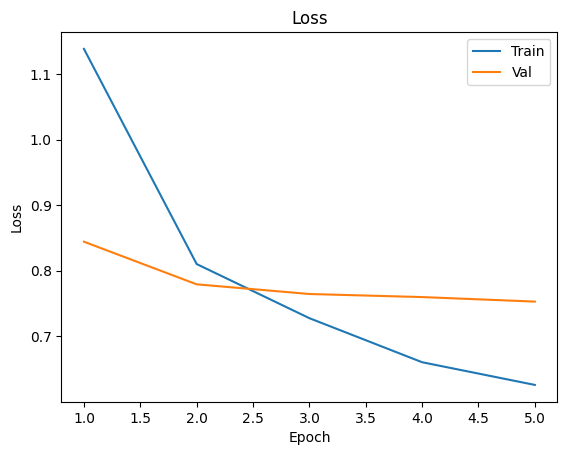

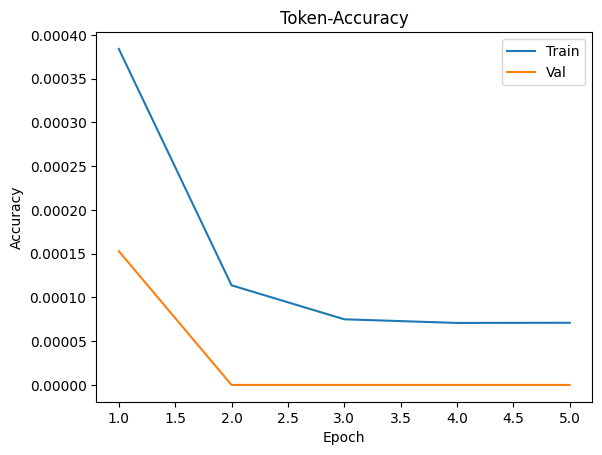


20 random examples:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Mild degenerative change with a mild condition and recommendations for further evaluation.
Generated :  FINDINGS: A suspicious erosion at the 5th MT head, specifically with a medial malleolar and subchondral cyst, with suspicious bone erosions, suggests RA involvement and warrants further investigation. 
Similarity: 0.2442


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a right first metatarsophalangeal joint erosions and degenerative change, likely associated with gout.
Generated :  FINDINGS: Both feet exhibit degenerative changes. 
Similarity: 0.4313


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has minimal osteoarthritis in both knees and evidence of ulnar joint involvement, suggesting further investigation is recommended.
Generated :  FINDINGS: The report indicates a degenerative change with a conclusion recommending further investigation. 
Similarity: 0.2919


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant bony abnormalities were found, and no significant abnormalities were detected.
Generated :  FINDINGS: Both ankles and wrists exhibit erosion. 
Similarity: 0.1672


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities, diagnosis pending, recommend further evaluation.
Generated :  FINDINGS: No bony abnormalities were identified, and no diagnosis was made. 
Similarity: 0.8157


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Diffuse osteopenia is a degenerative change, requiring ongoing monitoring.
Generated :  FINDINGS: The patient has pes planus in both feet, exhibiting degenerative changes. 
Similarity: 0.3963


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Mild periarticular osteopenia with a right first MTP joint, without signs of inflammatory or crystal-associated arthritis, requiring further investigation.
Generated :  FINDINGS: The patient has hallux valgus on both feet, suspicious for gout. 
Similarity: 0.2373


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change with a conclusion recommending further investigation and potential treatment.
Generated :  FINDINGS: The patient has a diagnosis of Osteoporosis-related soft tissue swelling in the left ankle joint and a diagnosis of gouty arthritis with suspicious opacity. 
Similarity: 0.2249


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Both 1st MTP joint erosion is likely caused by gout arthritis.
Generated :  FINDINGS: No bony abnormalities were found, and no soft tissue abnormalities were visible. 
Similarity: 0.1962


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient presents with suspicious bony erosions and osteopenia in the lateral navicular bone and multiple joints, suggesting a post-operative change due to gouty arthritis, requiring further clinical correlation and evaluation.
Generated :  FINDINGS: No bony abnormality, diagnosis: no bony abnormality, recommend further investigation. 
Similarity: 0.5124


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has soft tissue swelling in the left ankle with no bony erosion.
Generated :  FINDINGS: Both 5th MTP joint effusions are present, resulting in erosions of the accessory navicular bones and osteochondral and possible joint dislocations. 
Similarity: 0.3854


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has mild hallux valgus on the right foot, with osteoarthritis in both the first metatarsophalangeal joints (right and left).
Generated :  FINDINGS: The patient has periarticular osteopenia and calcifications in the left ankle with bilateral and right accessory navicular bones. 
Similarity: 0.4646


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change, recommending further investigation and potential management.
Generated :  FINDINGS: The patient has diffuse osteopenia, hallux valgus, ankle osteoarthritis, knee osteoarthritis, and joint space narrowing in both knees. 
Similarity: 0.3457


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities were found, and no soft tissue abnormalities were observed.
Generated :  FINDINGS: No significant bony lesion was identified on radiographs; no further action is recommended. 
Similarity: 0.7030


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant interval change, therefore no significant interval change, and no further recommendations are needed.
Generated :  FINDINGS: The report indicates a degenerative change, and further investigation is recommended. 
Similarity: 0.1593


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia, advanced RA in both feet and hands, significant joint space narrowing in the knees, suggestive of RA involvement in both the left shoulder and atlantoaxial subluxation, requiring further investigation and management.
Generated :  FINDINGS: No bony abnormality, diagnosis: no abnormality, recommend further investigation. 
Similarity: 0.4256


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Both ankles are exhibiting osteoarthritis.
Generated :  FINDINGS: The patient has right ankle osteoarthritis, hallux valgus, osteopenia, and gouty arthritis, with a history of old fracture and a previous fracture. 
Similarity: 0.6194


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient presents with right ankle osteoarthritis with bony erosion and multiple gout lesions, requiring further investigation and treatment.
Generated :  FINDINGS: No bony abnormality, diagnosis: no bony abnormality, recommend further evaluation. 
Similarity: 0.4051


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a left foot deformity (hallux valgus) and right ankle swelling, with a possible gout in the first metatarsophalangeal joint.
Generated :  FINDINGS: The patient has a degenerative change of both feet with calcifications and joint effusions on both feet, and is diagnosed with a degenerative change. 
Similarity: 0.5175


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, diagnosis: no abnormalities, recommend further evaluation.
Generated :  FINDINGS: The patient has diffuse osteopenia and degenerative changes, warranting further investigation. 
Similarity: 0.5292


Evaluating test set:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   0%|          | 1/240 [00:00<00:31,  7.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   1%|▏         | 3/240 [00:00<00:22, 10.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▏         | 5/240 [00:00<00:30,  7.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▎         | 6/240 [00:00<00:28,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   3%|▎         | 8/240 [00:00<00:27,  8.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   4%|▍         | 10/240 [00:01<00:25,  9.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▌         | 12/240 [00:01<00:22, 10.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   6%|▌         | 14/240 [00:01<00:24,  9.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 16/240 [00:01<00:23,  9.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 17/240 [00:01<00:25,  8.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 18/240 [00:02<00:25,  8.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 20/240 [00:02<00:23,  9.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   9%|▉         | 21/240 [00:02<00:23,  9.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|▉         | 23/240 [00:02<00:22,  9.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|█         | 25/240 [00:02<00:21, 10.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  11%|█▏        | 27/240 [00:02<00:23,  9.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▏        | 28/240 [00:03<00:27,  7.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▏        | 29/240 [00:03<00:26,  7.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  13%|█▎        | 31/240 [00:03<00:23,  8.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  13%|█▎        | 32/240 [00:03<00:23,  8.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  14%|█▍        | 34/240 [00:03<00:21,  9.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▍        | 35/240 [00:03<00:21,  9.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▌        | 37/240 [00:04<00:20, 10.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  16%|█▋        | 39/240 [00:04<00:19, 10.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  17%|█▋        | 41/240 [00:04<00:18, 10.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 43/240 [00:04<00:19, 10.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  19%|█▉        | 45/240 [00:04<00:19, 10.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|█▉        | 47/240 [00:05<00:20,  9.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|██        | 49/240 [00:05<00:20,  9.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  21%|██        | 50/240 [00:05<00:20,  9.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  21%|██▏       | 51/240 [00:05<00:23,  7.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▏       | 52/240 [00:05<00:23,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▏       | 53/240 [00:05<00:23,  7.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  23%|██▎       | 55/240 [00:06<00:21,  8.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  24%|██▍       | 57/240 [00:06<00:22,  8.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  24%|██▍       | 58/240 [00:06<00:23,  7.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▍       | 59/240 [00:06<00:22,  8.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▌       | 60/240 [00:06<00:21,  8.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  26%|██▌       | 62/240 [00:06<00:20,  8.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  27%|██▋       | 64/240 [00:07<00:20,  8.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  27%|██▋       | 65/240 [00:07<00:22,  7.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 66/240 [00:07<00:21,  8.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 67/240 [00:07<00:22,  7.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  29%|██▉       | 69/240 [00:07<00:19,  8.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  29%|██▉       | 70/240 [00:07<00:19,  8.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|███       | 72/240 [00:08<00:17,  9.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  31%|███       | 74/240 [00:08<00:17,  9.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  31%|███▏      | 75/240 [00:08<00:19,  8.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▏      | 76/240 [00:08<00:19,  8.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▏      | 77/240 [00:08<00:20,  7.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  33%|███▎      | 79/240 [00:08<00:18,  8.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  33%|███▎      | 80/240 [00:09<00:19,  8.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  34%|███▍      | 82/240 [00:09<00:17,  9.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▌      | 84/240 [00:09<00:15,  9.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▌      | 85/240 [00:09<00:16,  9.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  36%|███▋      | 87/240 [00:09<00:16,  9.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  37%|███▋      | 89/240 [00:09<00:16,  9.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 90/240 [00:10<00:15,  9.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 91/240 [00:10<00:19,  7.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  39%|███▉      | 93/240 [00:10<00:16,  8.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|███▉      | 95/240 [00:10<00:15,  9.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|████      | 96/240 [00:10<00:16,  8.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  41%|████      | 98/240 [00:11<00:15,  9.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▏     | 100/240 [00:11<00:14,  9.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▏     | 101/240 [00:11<00:15,  9.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  43%|████▎     | 103/240 [00:11<00:14,  9.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  44%|████▍     | 105/240 [00:11<00:14,  9.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▍     | 107/240 [00:11<00:13, 10.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▌     | 109/240 [00:12<00:12, 10.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  46%|████▋     | 111/240 [00:12<00:12, 10.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  47%|████▋     | 113/240 [00:12<00:13,  9.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 115/240 [00:12<00:12, 10.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  49%|████▉     | 117/240 [00:13<00:14,  8.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|████▉     | 119/240 [00:13<00:12,  9.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|█████     | 121/240 [00:13<00:12,  9.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  51%|█████     | 122/240 [00:13<00:12,  9.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  51%|█████▏    | 123/240 [00:13<00:12,  9.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▏    | 124/240 [00:13<00:14,  8.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▏    | 125/240 [00:13<00:13,  8.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▎    | 126/240 [00:14<00:13,  8.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  53%|█████▎    | 127/240 [00:14<00:13,  8.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  53%|█████▎    | 128/240 [00:14<00:13,  8.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  54%|█████▍    | 130/240 [00:14<00:12,  9.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▍    | 131/240 [00:14<00:13,  8.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▌    | 133/240 [00:14<00:11,  8.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  56%|█████▌    | 134/240 [00:14<00:12,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▋    | 136/240 [00:15<00:10,  9.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▋    | 137/240 [00:15<00:11,  8.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▊    | 138/240 [00:15<00:12,  8.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  58%|█████▊    | 139/240 [00:15<00:13,  7.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  58%|█████▊    | 140/240 [00:15<00:13,  7.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  59%|█████▉    | 141/240 [00:15<00:14,  6.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|█████▉    | 143/240 [00:16<00:12,  7.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|██████    | 145/240 [00:16<00:11,  8.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  61%|██████    | 146/240 [00:16<00:11,  8.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  61%|██████▏   | 147/240 [00:16<00:10,  8.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▏   | 148/240 [00:16<00:10,  8.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▏   | 149/240 [00:16<00:10,  8.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  63%|██████▎   | 151/240 [00:17<00:11,  7.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  63%|██████▎   | 152/240 [00:17<00:10,  8.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 153/240 [00:17<00:10,  8.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 154/240 [00:17<00:09,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▍   | 155/240 [00:17<00:10,  8.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 156/240 [00:17<00:11,  7.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 157/240 [00:17<00:11,  7.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  66%|██████▌   | 158/240 [00:17<00:10,  7.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  66%|██████▋   | 159/240 [00:18<00:10,  7.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 160/240 [00:18<00:11,  6.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 161/240 [00:18<00:11,  6.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 163/240 [00:18<00:10,  7.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  69%|██████▉   | 165/240 [00:18<00:08,  8.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|██████▉   | 167/240 [00:19<00:08,  8.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|███████   | 168/240 [00:19<00:07,  9.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  71%|███████   | 170/240 [00:19<00:07,  9.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  71%|███████▏  | 171/240 [00:19<00:07,  8.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▏  | 172/240 [00:19<00:07,  8.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▏  | 173/240 [00:19<00:07,  8.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  73%|███████▎  | 175/240 [00:19<00:06,  9.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  74%|███████▍  | 177/240 [00:20<00:06,  9.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  74%|███████▍  | 178/240 [00:20<00:06,  9.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▌  | 180/240 [00:20<00:05, 10.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  76%|███████▌  | 182/240 [00:20<00:05, 10.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  77%|███████▋  | 184/240 [00:20<00:05, 10.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 186/240 [00:20<00:05, 10.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 188/240 [00:21<00:05,  9.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  79%|███████▉  | 190/240 [00:21<00:05,  9.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|████████  | 192/240 [00:21<00:05,  8.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  81%|████████  | 194/240 [00:21<00:04,  9.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▏ | 196/240 [00:21<00:04,  9.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▏ | 197/240 [00:22<00:04,  9.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▎ | 198/240 [00:22<00:04,  8.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  83%|████████▎ | 199/240 [00:22<00:04,  8.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  83%|████████▎ | 200/240 [00:22<00:05,  7.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  84%|████████▍ | 202/240 [00:22<00:04,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▍ | 203/240 [00:22<00:04,  8.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▌ | 205/240 [00:23<00:04,  8.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  86%|████████▋ | 207/240 [00:23<00:03,  9.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  87%|████████▋ | 208/240 [00:23<00:03,  9.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  87%|████████▋ | 209/240 [00:23<00:03,  8.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 210/240 [00:23<00:03,  8.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 211/240 [00:23<00:03,  7.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 212/240 [00:23<00:03,  7.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  89%|████████▉ | 214/240 [00:24<00:03,  7.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|█████████ | 216/240 [00:24<00:02,  8.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|█████████ | 217/240 [00:24<00:02,  8.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  91%|█████████ | 218/240 [00:24<00:02,  8.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  91%|█████████▏| 219/240 [00:24<00:02,  8.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▏| 220/240 [00:24<00:02,  8.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▎| 222/240 [00:25<00:02,  8.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  93%|█████████▎| 224/240 [00:25<00:01,  8.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  94%|█████████▍| 225/240 [00:25<00:01,  8.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  94%|█████████▍| 226/240 [00:25<00:01,  8.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▍| 227/240 [00:25<00:01,  8.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▌| 228/240 [00:25<00:01,  8.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  96%|█████████▌| 230/240 [00:26<00:01,  8.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  97%|█████████▋| 232/240 [00:26<00:00,  8.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  97%|█████████▋| 233/240 [00:26<00:00,  7.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 235/240 [00:26<00:00,  7.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  99%|█████████▉| 237/240 [00:26<00:00,  8.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  99%|█████████▉| 238/240 [00:27<00:00,  8.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|█████████▉| 239/240 [00:27<00:00,  7.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|██████████| 240/240 [00:27<00:00,  8.76it/s]
2025-05-22 12:03:33,153 | INFO | 
Average semantic similarity over 240 test samples: 0.4288


In [5]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None):
        self.tokenizer = tokenizer
        self.image_transform = image_transform or transforms.Compose([
            # Resize all images to exactly 256×256
            transforms.Resize((256, 256)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.95, 1.05)
            ),
            transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        items = []
        for item in raw:
            path = item.get('merged_image_path', '')
            if os.path.exists(path):
                items.append((path, item.get('cleaned_report', '')))

        self.data = items

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, clean_text = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.image_transform(img)

        prompt = f"{self.tokenizer.bos_token} FINDINGS: {clean_text} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     clean_text
        }

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'clean_text':     clean_txt
    }

# ----------------------------
# 2. Vision Encoder w/ 4× Cross-Attention (Swin V2)
# ----------------------------
class VisionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        # Swin Transformer V2 backbone
        self.global_enc  = timm.create_model(
            'swinv2_base_window12to16_192to256_22kft1k',
            pretrained=True,
            num_classes=0
        )
        self.global_proj = nn.Linear(self.global_enc.num_features, vision_dim)

        # four stacked self-attention layers on the singleton token
        self.cross_attn1 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm1       = nn.LayerNorm(vision_dim)
        self.cross_attn2 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm2       = nn.LayerNorm(vision_dim)
        self.cross_attn3 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm3       = nn.LayerNorm(vision_dim)
        self.cross_attn4 = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm4       = nn.LayerNorm(vision_dim)

    def forward(self, full_img):
        # full_img: (B,3,224,224)
        feats = self.global_enc(full_img)     # (B, C)
        g     = self.global_proj(feats)       # (B, D)
        g     = g.unsqueeze(1)                # (B, 1, D)

        # layer 1
        q1, _ = self.cross_attn1(g, g, g)
        f1    = self.norm1(q1 + g)
        # layer 2
        q2, _ = self.cross_attn2(f1, f1, f1)
        f2    = self.norm2(q2 + f1)
        # layer 3
        q3, _ = self.cross_attn3(f2, f2, f2)
        f3    = self.norm3(q3 + f2)
        # layer 4
        q4, _ = self.cross_attn4(f3, f3, f3)
        f4    = self.norm4(q4 + f3)

        return f4  # (B, 1, D)

# ----------------------------
# 3. Report Generator
# ----------------------------
class MedicalReportGenerator(nn.Module):
    def __init__(self, tokenizer, vision_dim=768, gpt2_model='gpt2', device='cuda', sem_coef=0.1):
        super().__init__()
        self.device    = device
        self.tokenizer = tokenizer
        self.embedder  = SentenceTransformer('all-MiniLM-L6-v2')
        self.sem_coef  = sem_coef

        self.encoder   = VisionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder   = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, input_ids, attention_mask, clean_texts, labels=None):
        vt = self.encoder(full_img)                               # (B,1,D)
        vm = torch.ones(vt.size()[:2], device=self.device)        # (B,1)

        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels,
            return_dict=True
        )
        ce_loss = outputs.loss

        # semantic loss
        with torch.no_grad():
            gen_ids   = outputs.logits.argmax(-1)
            gen_texts = [self.tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids]
            emb_gen   = self.embedder.encode(
                gen_texts, convert_to_tensor=True, device=self.device, show_progress_bar=False
            )
            emb_truth = self.embedder.encode(
                clean_texts, convert_to_tensor=True, device=self.device, show_progress_bar=False
            )
        sims     = util.cos_sim(emb_gen, emb_truth)
        sem_loss = torch.mean(1.0 - sims.diag())

        loss = ce_loss + self.sem_coef * sem_loss
        return loss, outputs.logits

# ----------------------------
# 4. Training & Eval
# ----------------------------
def train_epoch(model, loader, optimizer, scheduler=None, epoch=0):
    model.train()
    total_loss = total_acc = n = 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full  = batch['full_img'].to(model.device)
        ids   = batch['input_ids'].to(model.device)
        mask  = batch['attention_mask'].to(model.device)
        clean = batch['clean_text']

        optimizer.zero_grad()
        loss, logits = model(full, ids, mask, clean, labels=ids)
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        preds = logits.argmax(-1)
        acc   = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        total_loss += loss.item() * bsz
        total_acc  += acc * bsz
        n          += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    total_loss = total_acc = n = 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full  = batch['full_img'].to(model.device)
        ids   = batch['input_ids'].to(model.device)
        mask  = batch['attention_mask'].to(model.device)
        clean = batch['clean_text']

        loss, logits = model(full, ids, mask, clean, labels=ids)
        preds = logits.argmax(-1)
        acc   = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        total_loss += loss.item() * bsz
        total_acc  += acc * bsz
        n          += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / n, total_acc / n

# ----------------------------
# 5. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses)
    plt.plot(epochs, val_losses)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accs)
    plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Val'])
    plt.show()

# ----------------------------
# 6. Main
# ----------------------------
def main():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s | %(levelname)s | %(message)s',
        handlers=[logging.FileHandler("training.log"), logging.StreamHandler()]
    )

    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 5, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # data
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model     = MedicalReportGenerator(tokenizer, device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for ep in range(1, EPOCHS+1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader,   epoch=ep)
        logging.info(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l); val_losses.append(va_l)
        train_accs.append(tr_a);   val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # test sampling + semantic similarity
    model.eval()
    print("\n20 random examples:")
    examples = random.sample(range(len(te)), 20)
    for idx in examples:
        batch      = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img   = batch['full_img'].to(DEVICE)
        clean_text = batch['clean_text'][0]

        vt = model.encoder(full_img)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out    = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb = model.embedder.encode([gen, clean_text], convert_to_tensor=True, device=DEVICE)
        sim = util.cos_sim(emb[0], emb[1]).item()

        print("—"*40)
        print("Clean     :", clean_text)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")

    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set"):
        full_img   = batch['full_img'].to(DEVICE)
        clean_text = batch['clean_text'][0]

        vt = model.encoder(full_img)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out    = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen      = tokenizer.decode(out[0], skip_special_tokens=True)
        emb_pair = model.embedder.encode([gen, clean_text], convert_to_tensor=True, device=DEVICE)
        sims.append(util.cos_sim(emb_pair[0], emb_pair[1]).item())

    overall = float(np.mean(sims))
    logging.info(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")

if __name__ == '__main__':
    main()


## Swin V2 with ResNet50

2025-05-22 12:14:20,762 | INFO | Use pytorch device_name: cuda
2025-05-22 12:14:20,763 | INFO | Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-22 12:14:22,109 | INFO | Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window12to16_192to256.ms_in22k_ft_in1k)
2025-05-22 12:14:22,214 | INFO | [timm/swinv2_base_window12to16_192to256.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_pr

Epoch 01 → train_loss=1.1354, val_loss=0.8313, train_acc=0.0003, val_acc=0.0000


Epoch 02 → train_loss=0.7918, val_loss=0.7762, train_acc=0.0001, val_acc=0.0000


Epoch 03 → train_loss=0.7025, val_loss=0.7623, train_acc=0.0001, val_acc=0.0000


Epoch 04 → train_loss=0.6506, val_loss=0.7460, train_acc=0.0000, val_acc=0.0000


Epoch 05 → train_loss=0.6073, val_loss=0.7452, train_acc=0.0001, val_acc=0.0000


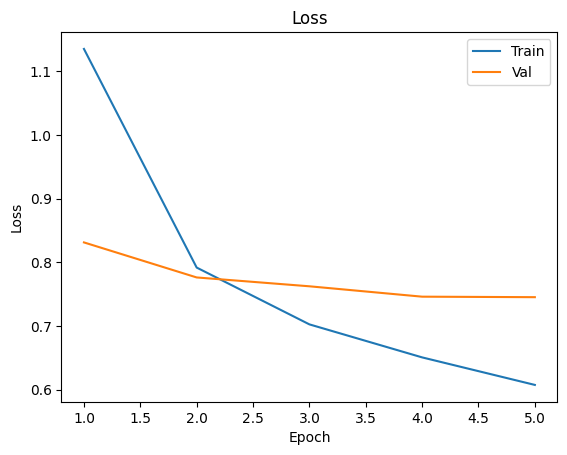

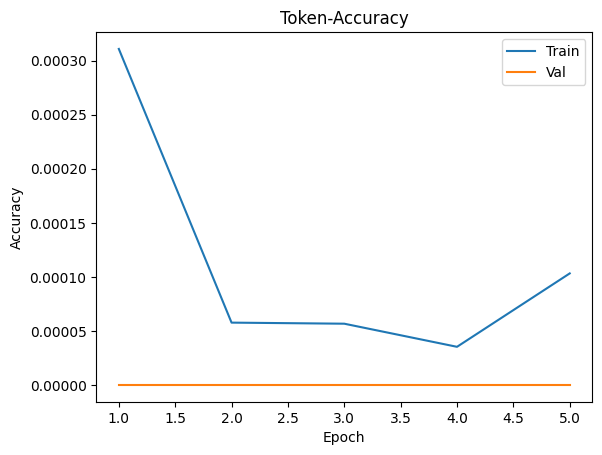


20 random examples:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has gout in both of their first metatarsophalangeal joints.
Generated :  FINDINGS: No bony lesion found; no findings warrant further action. 
Similarity: 0.3491


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a right accessory navicular bone type II with osteoarthritis.
Generated :  FINDINGS: No bony abnormalities were found, and there are no soft tissue abnormalities. 
Similarity: 0.2762


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has mild hallux valgus on the right foot, with osteoarthritis in both the first metatarsophalangeal joints (right and left).
Generated :  FINDINGS: No significant bony lesion was identified on radiographs. 
Similarity: 0.3662


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, therefore no abnormalities were detected.
Generated :  FINDINGS: No bony lesion, diagnosis: no bony lesion. 
Similarity: 0.7095


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has pes planus on both feet.
Generated :  FINDINGS: The report indicates a degenerative change, recommending further investigation and potential treatment. 
Similarity: 0.2610


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a subacromial spur on both shoulders, which is diagnosed as non-significant on radiographs and shows a positive ulnar variance.
Generated :  FINDINGS: The patient has mild degenerative changes in both ankles and ankles. 
Similarity: 0.3804


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Left Hallux Valgus on the left foot.
Generated :  FINDINGS: No bony lesion, diagnosis: no bony lesion. 
Similarity: 0.2869


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has joint space narrowing and erosions at both the first and fourth MT joints, suggesting a possible rheumatoid arthritis diagnosis and recommends further evaluation.
Generated :  FINDINGS: Diffuse osteopenia is a degenerative change. 
Similarity: 0.3612


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony lesion, diagnosis: no bony lesion, recommend further evaluation.
Generated :  FINDINGS: There is no bony abnormality, and the patient is diagnosed as being healthy. 
Similarity: 0.7740


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Both 1st MTP joint erosion is likely caused by gout arthritis.
Generated :  FINDINGS: A suspicious small calcification is present in the right lateral aspect of the right wrist. 
Similarity: 0.1371


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has calcaneal spurs on both legs, a humeral neck cyst in the right shoulder, minimal cervical spondylosis, and suggestive evidence of rheumatoid arthritis affecting both wrists.
Generated :  FINDINGS: The patient has a diagnosis of hallux valgus on the right first metatarsal and lateral malleolus, requiring further investigation. 
Similarity: 0.3775


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient experienced degenerative change following surgery.
Generated :  FINDINGS: The patient presents with osteoarthritis, potentially due to gout, and has suspected fractures and soft tissue swelling in the right 4th metatarsal. 
Similarity: 0.2386


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has advanced rheumatoid arthritis (RA) affecting both hands, feet, and the atlantoaxial joint with no instability, osteopenia, and no demonstrable instability.
Generated :  FINDINGS: The report indicates a degenerative change and recommends further investigation and potential treatment. 
Similarity: 0.3096


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The report indicates a degenerative change, recommending further investigation and potential management.
Generated :  FINDINGS: The patient has diffuse osteopenia with a right first metatarsophalangeal joint osteoarthritis. 
Similarity: 0.2895


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and degenerative changes.
Generated :  FINDINGS: No bony abnormalities were found, and no soft tissue abnormalities were seen. 
Similarity: 0.3401


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and degenerative change in both ankles, with both ankles exhibiting soft tissue swelling.
Generated :  FINDINGS: Both feet exhibit osteoarthritis. 
Similarity: 0.4977


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities were found, and no further action is recommended.
Generated :  FINDINGS: The report indicates a degenerative change, recommending further investigation and potential treatment. 
Similarity: 0.3270


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No significant bony lesion was found on radiographs, and no recommendations are needed.
Generated :  FINDINGS: No bony lesion, diagnosis: no bony lesion. 
Similarity: 0.7695


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony lesions, with no findings of bony damage.
Generated :  FINDINGS: The patient has pes planus in both feet. 
Similarity: 0.2760


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia with right 5th MTP joint swelling and osteoarthritis in both hands and feet.
Generated :  FINDINGS: Both ankles exhibit RA involvement with diffuse osteopenia and degenerative changes, with a previous RA diagnosis, and treatment recommendations. 
Similarity: 0.5907


Evaluating test set:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   1%|          | 2/240 [00:00<00:25,  9.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   1%|▏         | 3/240 [00:00<00:25,  9.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▏         | 4/240 [00:00<00:26,  9.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▏         | 5/240 [00:00<00:26,  8.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   2%|▎         | 6/240 [00:00<00:26,  8.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   3%|▎         | 8/240 [00:00<00:25,  8.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   4%|▍         | 9/240 [00:01<00:25,  8.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   4%|▍         | 10/240 [00:01<00:27,  8.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▍         | 11/240 [00:01<00:28,  8.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▌         | 12/240 [00:01<00:27,  8.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   5%|▌         | 13/240 [00:01<00:29,  7.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   6%|▌         | 14/240 [00:01<00:27,  8.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   6%|▋         | 15/240 [00:01<00:28,  7.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 16/240 [00:01<00:28,  7.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   7%|▋         | 17/240 [00:02<00:27,  8.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 18/240 [00:02<00:27,  8.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 19/240 [00:02<00:28,  7.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   8%|▊         | 20/240 [00:02<00:28,  7.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   9%|▉         | 21/240 [00:02<00:28,  7.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:   9%|▉         | 22/240 [00:02<00:28,  7.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|█         | 24/240 [00:02<00:25,  8.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  10%|█         | 25/240 [00:02<00:24,  8.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  11%|█         | 26/240 [00:03<00:26,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  11%|█▏        | 27/240 [00:03<00:28,  7.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▏        | 28/240 [00:03<00:27,  7.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▏        | 29/240 [00:03<00:26,  7.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  12%|█▎        | 30/240 [00:03<00:26,  7.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  13%|█▎        | 31/240 [00:03<00:26,  7.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  13%|█▎        | 32/240 [00:03<00:25,  8.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  14%|█▍        | 33/240 [00:04<00:25,  8.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  14%|█▍        | 34/240 [00:04<00:25,  8.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▍        | 35/240 [00:04<00:24,  8.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▌        | 36/240 [00:04<00:28,  7.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  15%|█▌        | 37/240 [00:04<00:26,  7.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  16%|█▌        | 38/240 [00:04<00:24,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  17%|█▋        | 40/240 [00:04<00:22,  8.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  17%|█▋        | 41/240 [00:04<00:22,  9.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 42/240 [00:05<00:23,  8.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  18%|█▊        | 44/240 [00:05<00:22,  8.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  19%|█▉        | 45/240 [00:05<00:23,  8.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|█▉        | 47/240 [00:05<00:22,  8.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|██        | 48/240 [00:05<00:21,  8.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  20%|██        | 49/240 [00:05<00:21,  8.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  21%|██        | 50/240 [00:06<00:24,  7.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  21%|██▏       | 51/240 [00:06<00:23,  8.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▏       | 52/240 [00:06<00:22,  8.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▏       | 53/240 [00:06<00:22,  8.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  22%|██▎       | 54/240 [00:06<00:21,  8.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  23%|██▎       | 55/240 [00:06<00:21,  8.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  23%|██▎       | 56/240 [00:06<00:21,  8.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  24%|██▍       | 58/240 [00:06<00:20,  8.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▍       | 59/240 [00:07<00:19,  9.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  25%|██▌       | 60/240 [00:07<00:19,  9.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  26%|██▌       | 62/240 [00:07<00:18,  9.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  27%|██▋       | 64/240 [00:07<00:18,  9.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  27%|██▋       | 65/240 [00:07<00:19,  9.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 67/240 [00:07<00:19,  8.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  28%|██▊       | 68/240 [00:08<00:19,  8.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  29%|██▉       | 69/240 [00:08<00:22,  7.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|██▉       | 71/240 [00:08<00:20,  8.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|███       | 72/240 [00:08<00:19,  8.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  30%|███       | 73/240 [00:08<00:19,  8.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  31%|███       | 74/240 [00:08<00:20,  8.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  31%|███▏      | 75/240 [00:08<00:21,  7.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▏      | 76/240 [00:09<00:20,  7.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▏      | 77/240 [00:09<00:20,  7.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  32%|███▎      | 78/240 [00:09<00:20,  7.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  33%|███▎      | 79/240 [00:09<00:19,  8.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  33%|███▎      | 80/240 [00:09<00:19,  8.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  34%|███▍      | 81/240 [00:09<00:20,  7.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  34%|███▍      | 82/240 [00:09<00:19,  7.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▌      | 84/240 [00:10<00:18,  8.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  35%|███▌      | 85/240 [00:10<00:18,  8.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  36%|███▌      | 86/240 [00:10<00:18,  8.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  36%|███▋      | 87/240 [00:10<00:17,  8.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  37%|███▋      | 88/240 [00:10<00:19,  7.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  37%|███▋      | 89/240 [00:10<00:19,  7.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 90/240 [00:10<00:20,  7.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 91/240 [00:10<00:19,  7.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  38%|███▊      | 92/240 [00:11<00:18,  8.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  39%|███▉      | 93/240 [00:11<00:17,  8.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  39%|███▉      | 94/240 [00:11<00:17,  8.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|███▉      | 95/240 [00:11<00:16,  8.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|████      | 96/240 [00:11<00:17,  8.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  40%|████      | 97/240 [00:11<00:16,  8.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  41%|████      | 98/240 [00:11<00:15,  8.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  41%|████▏     | 99/240 [00:11<00:15,  8.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▏     | 100/240 [00:12<00:16,  8.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▏     | 101/240 [00:12<00:15,  8.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  42%|████▎     | 102/240 [00:12<00:15,  8.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  43%|████▎     | 103/240 [00:12<00:15,  9.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  43%|████▎     | 104/240 [00:12<00:17,  7.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  44%|████▍     | 105/240 [00:12<00:17,  7.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  44%|████▍     | 106/240 [00:12<00:16,  8.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▍     | 107/240 [00:12<00:16,  8.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▌     | 108/240 [00:12<00:16,  8.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  45%|████▌     | 109/240 [00:13<00:18,  6.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  46%|████▌     | 110/240 [00:13<00:17,  7.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  46%|████▋     | 111/240 [00:13<00:17,  7.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  47%|████▋     | 112/240 [00:13<00:16,  7.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  47%|████▋     | 113/240 [00:13<00:15,  8.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 114/240 [00:13<00:15,  8.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 115/240 [00:13<00:14,  8.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  48%|████▊     | 116/240 [00:13<00:14,  8.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  49%|████▉     | 117/240 [00:14<00:14,  8.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  49%|████▉     | 118/240 [00:14<00:15,  7.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|████▉     | 119/240 [00:14<00:14,  8.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|█████     | 120/240 [00:14<00:15,  7.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  50%|█████     | 121/240 [00:14<00:14,  8.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  51%|█████     | 122/240 [00:14<00:14,  8.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  51%|█████▏    | 123/240 [00:14<00:14,  8.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▏    | 124/240 [00:14<00:13,  8.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▏    | 125/240 [00:15<00:13,  8.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  52%|█████▎    | 126/240 [00:15<00:14,  7.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  53%|█████▎    | 127/240 [00:15<00:13,  8.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  54%|█████▍    | 129/240 [00:15<00:12,  8.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  54%|█████▍    | 130/240 [00:15<00:13,  8.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▍    | 131/240 [00:15<00:13,  8.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▌    | 132/240 [00:15<00:13,  8.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  55%|█████▌    | 133/240 [00:16<00:12,  8.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  56%|█████▌    | 134/240 [00:16<00:12,  8.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▋    | 136/240 [00:16<00:12,  8.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▋    | 137/240 [00:16<00:12,  7.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  57%|█████▊    | 138/240 [00:16<00:13,  7.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  58%|█████▊    | 139/240 [00:16<00:13,  7.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  59%|█████▉    | 141/240 [00:17<00:12,  8.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  59%|█████▉    | 142/240 [00:17<00:11,  8.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|█████▉    | 143/240 [00:17<00:12,  7.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|██████    | 144/240 [00:17<00:13,  6.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  60%|██████    | 145/240 [00:17<00:13,  7.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  61%|██████    | 146/240 [00:17<00:13,  6.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  61%|██████▏   | 147/240 [00:17<00:13,  7.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▏   | 148/240 [00:18<00:12,  7.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▏   | 149/240 [00:18<00:12,  7.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  62%|██████▎   | 150/240 [00:18<00:11,  7.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  63%|██████▎   | 151/240 [00:18<00:11,  7.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  63%|██████▎   | 152/240 [00:18<00:11,  7.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 153/240 [00:18<00:11,  7.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  64%|██████▍   | 154/240 [00:18<00:11,  7.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▍   | 155/240 [00:18<00:10,  7.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 156/240 [00:19<00:10,  8.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  65%|██████▌   | 157/240 [00:19<00:10,  8.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  66%|██████▌   | 158/240 [00:19<00:10,  7.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  66%|██████▋   | 159/240 [00:19<00:09,  8.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 160/240 [00:19<00:09,  8.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  67%|██████▋   | 161/240 [00:19<00:09,  8.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 162/240 [00:19<00:09,  8.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 163/240 [00:19<00:09,  8.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  68%|██████▊   | 164/240 [00:20<00:09,  7.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  69%|██████▉   | 165/240 [00:20<00:09,  8.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  69%|██████▉   | 166/240 [00:20<00:09,  7.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|██████▉   | 167/240 [00:20<00:09,  7.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  70%|███████   | 168/240 [00:20<00:09,  7.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  71%|███████   | 170/240 [00:20<00:09,  7.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  71%|███████▏  | 171/240 [00:20<00:09,  7.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▏  | 172/240 [00:21<00:08,  7.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  72%|███████▏  | 173/240 [00:21<00:09,  7.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  73%|███████▎  | 175/240 [00:21<00:07,  8.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  73%|███████▎  | 176/240 [00:21<00:08,  7.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  74%|███████▍  | 177/240 [00:21<00:07,  8.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  74%|███████▍  | 178/240 [00:21<00:07,  7.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▍  | 179/240 [00:21<00:07,  8.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▌  | 180/240 [00:22<00:07,  8.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  75%|███████▌  | 181/240 [00:22<00:06,  8.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  76%|███████▌  | 182/240 [00:22<00:06,  8.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  76%|███████▋  | 183/240 [00:22<00:06,  8.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  77%|███████▋  | 184/240 [00:22<00:06,  8.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  77%|███████▋  | 185/240 [00:22<00:06,  8.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 187/240 [00:22<00:05,  9.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  78%|███████▊  | 188/240 [00:22<00:05,  9.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  79%|███████▉  | 189/240 [00:23<00:05,  9.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  79%|███████▉  | 190/240 [00:23<00:05,  8.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|███████▉  | 191/240 [00:23<00:05,  9.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|████████  | 192/240 [00:23<00:05,  8.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  80%|████████  | 193/240 [00:23<00:05,  8.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  81%|████████▏ | 195/240 [00:23<00:04,  9.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▏ | 196/240 [00:23<00:04,  9.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▏ | 197/240 [00:23<00:04,  9.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  82%|████████▎ | 198/240 [00:24<00:04,  8.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  83%|████████▎ | 199/240 [00:24<00:04,  8.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  83%|████████▎ | 200/240 [00:24<00:04,  8.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  84%|████████▍ | 201/240 [00:24<00:04,  8.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  84%|████████▍ | 202/240 [00:24<00:04,  7.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▍ | 203/240 [00:24<00:04,  8.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  85%|████████▌ | 205/240 [00:24<00:03,  8.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  86%|████████▌ | 206/240 [00:25<00:03,  8.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  86%|████████▋ | 207/240 [00:25<00:03,  8.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  87%|████████▋ | 208/240 [00:25<00:04,  7.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  87%|████████▋ | 209/240 [00:25<00:04,  7.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 210/240 [00:25<00:03,  7.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 211/240 [00:25<00:04,  6.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  88%|████████▊ | 212/240 [00:25<00:04,  6.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  89%|████████▉ | 214/240 [00:26<00:03,  7.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|████████▉ | 215/240 [00:26<00:03,  8.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  90%|█████████ | 216/240 [00:26<00:03,  7.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  91%|█████████ | 218/240 [00:26<00:02,  7.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  91%|█████████▏| 219/240 [00:26<00:02,  8.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▏| 220/240 [00:26<00:02,  8.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▏| 221/240 [00:26<00:02,  8.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  92%|█████████▎| 222/240 [00:27<00:02,  8.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  93%|█████████▎| 223/240 [00:27<00:02,  8.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  93%|█████████▎| 224/240 [00:27<00:02,  7.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  94%|█████████▍| 226/240 [00:27<00:01,  8.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▍| 227/240 [00:27<00:01,  8.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  95%|█████████▌| 229/240 [00:27<00:01,  8.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  96%|█████████▌| 230/240 [00:28<00:01,  8.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  96%|█████████▋| 231/240 [00:28<00:01,  8.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  97%|█████████▋| 232/240 [00:28<00:00,  8.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  97%|█████████▋| 233/240 [00:28<00:01,  6.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 234/240 [00:28<00:00,  7.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 235/240 [00:28<00:00,  7.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  98%|█████████▊| 236/240 [00:28<00:00,  8.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  99%|█████████▉| 237/240 [00:28<00:00,  7.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set:  99%|█████████▉| 238/240 [00:29<00:00,  6.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|█████████▉| 239/240 [00:29<00:00,  7.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating test set: 100%|██████████| 240/240 [00:29<00:00,  8.16it/s]
2025-05-22 12:27:19,581 | INFO | 
Average semantic similarity over 240 test samples: 0.4623


In [ ]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
import cv2
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None, patch_transform=None):
        self.tokenizer = tokenizer
        # Default image transform with mild geometric augmentations
        self.image_transform = image_transform or transforms.Compose([
            transforms.Resize((256, 256)),  # ensure compatibility with SwinV2 resolution
            transforms.RandomAffine(
                degrees=10,             # ±10°
                translate=(0.1, 0.1),   # ±10% translation
                scale=(0.95, 1.05)      # 0.95×–1.05× scaling
            ),
            transforms.ToTensor()
        ])
        # Default patch transform with the same mild augmentations
        self.patch_transform = patch_transform or transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.95, 1.05)
            ),
            transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        filtered = []
        for item in raw:
            merged = item.get('merged_image_path','')
            fps = item.get('file_paths',[])
            if isinstance(fps,str): fps=[fps]
            paths = [merged] + fps
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged,fps,item))

        self.data = {}
        for i,(merged,fps,item) in enumerate(filtered):
            self.data[i] = {
                'full': merged,
                'patches': fps,
                'keypoints': item.get('keypoints',{}),
                'clean': item.get('cleaned_report','')
            }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        # full image
        img = Image.open(e['full']).convert('RGB')
        img = self.image_transform(img)
        # patches
        patches = self._gen_patches(e['patches'], e['keypoints'])
        pt = [ self.patch_transform(Image.fromarray(p)) for p in patches ]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        # tokenize
        prompt = f"{self.tokenizer.bos_token} FINDINGS: {e['clean']} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     e['clean']
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst=[]; pts=side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0)
                    y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1])
                    y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            p=paths[0]
            if os.path.exists(p):
                arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr,kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr,kps_dict['right'])
        else:
            for side,p in zip(['left','right'],paths):
                if p and os.path.exists(p):
                    arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst=extract(arr,kps_dict[side])
                        (left if side=='left' else right).extend(lst)

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left=[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])
        return pad17(left)+pad17(right)

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    patches   = torch.stack([b['patches']   for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'patches':        patches,
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'clean_text':     clean_txt
    }

# ----------------------------
# 2. Model
# ----------------------------
class VisionFusionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        # ─── Swin V2 Base (dynamic window & resolution) ───
        self.global_enc = timm.create_model(
            'swinv2_base_window12to16_192to256',
            pretrained=True,
            num_classes=0
        )
        self.global_proj = nn.Linear(self.global_enc.num_features, vision_dim)
        # ───────────────────────────────────────────────

        res = models.resnet50(pretrained=True)
        res.fc = nn.Identity()
        self.patch_enc    = res
        self.patch_proj   = nn.Linear(2048, vision_dim)

        self.cross_attn1  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm1        = nn.LayerNorm(vision_dim)
        self.cross_attn2  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm2        = nn.LayerNorm(vision_dim)

    def forward(self, full_img, patches):
        B = full_img.size(0)
        g = self.global_proj(self.global_enc(full_img))           # B×D
        P = patches.view(-1,3,112,112)
        p = self.patch_proj(self.patch_enc(P)).view(B,34,-1)      # B×34×D

        q1, _    = self.cross_attn1(g.unsqueeze(1), p, p)         # B×1×D
        fused1   = self.norm1(q1.squeeze(1) + g)                  # B×D
        q2, _    = self.cross_attn2(fused1.unsqueeze(1), p, p)    # B×1×D
        fused2   = self.norm2(q2.squeeze(1) + fused1)             # B×D

        return torch.cat([fused2.unsqueeze(1), p], dim=1)         # B×35×D

class MedicalReportGenerator(nn.Module):
    def __init__(self, tokenizer, vision_dim=768, gpt2_model='gpt2', device='cuda', sem_coef=0.1):
        super().__init__()
        self.device    = device
        self.tokenizer = tokenizer
        self.embedder  = SentenceTransformer('all-MiniLM-L6-v2')
        self.sem_coef  = sem_coef
        self.encoder   = VisionFusionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder   = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, patches, input_ids, attention_mask, clean_texts, labels=None):
        # encode vision
        vt = self.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=self.device)
        # decode with cross-attention
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels,
            return_dict=True
        )
        ce_loss = outputs.loss

        # semantic-aware loss
        with torch.no_grad():
            gen_ids = outputs.logits.argmax(-1)
            gen_texts = [ self.tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids ]
            emb_gen   = self.embedder.encode(
                gen_texts,
                convert_to_tensor=True,
                device=self.device,
                show_progress_bar=False
            )
            emb_truth = self.embedder.encode(
                clean_texts,
                convert_to_tensor=True,
                device=self.device,
                show_progress_bar=False
            )
        sims      = util.cos_sim(emb_gen, emb_truth)  # (batch, batch)
        sem_loss  = torch.mean(1.0 - sims.diag())

        loss = ce_loss + self.sem_coef * sem_loss
        return loss, outputs.logits

# ----------------------------
# 3. Training & Eval
# ----------------------------
def train_epoch(model, loader, optim, scheduler=None, epoch=0):
    model.train()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        optim.zero_grad()
        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        loss.backward()
        optim.step()
        if scheduler: scheduler.step()

        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

# ----------------------------
# 4. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(); plt.plot(epochs, train_losses);   plt.plot(epochs, val_losses)
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.show()
    plt.figure(); plt.plot(epochs, train_accs);   plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(['Train','Val']); plt.show()

# ----------------------------
# 5. Main
# ----------------------------
def main():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s | %(levelname)s | %(message)s',
        handlers=[
            logging.FileHandler("training.log"),
            logging.StreamHandler()
        ]
    )
    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 5, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # data & splits
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model = MedicalReportGenerator(tokenizer, device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for ep in range(1, EPOCHS + 1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader, epoch=ep)
        print(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l)
        val_losses.append(va_l)
        train_accs.append(tr_a)
        val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # ----------------------------
    # 6. Test: sampling + overall similarity
    # ----------------------------
    model.eval()

    print("\n20 random examples:")
    examples = random.sample(range(len(te)), 20)
    for idx in examples:
        batch = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)

        emb = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sim = util.cos_sim(emb[0], emb[1]).item()

        print("—" * 40)
        print("Clean     :", clean_txt)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")

    # overall average
    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set", disable=True):
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb_pair = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sims.append(util.cos_sim(emb_pair[0], emb_pair[1]).item())

    overall = float(np.mean(sims))
    logging.info(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")

if __name__ == '__main__':
    main()


## Temperature = 0.1

2025-05-22 12:55:29,314 | INFO | Use pytorch device_name: cuda
2025-05-22 12:55:29,314 | INFO | Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-22 12:55:30,682 | INFO | Loading pretrained weights from Hugging Face hub (timm/swinv2_base_window12to16_192to256.ms_in22k_ft_in1k)
2025-05-22 12:55:30,784 | INFO | [timm/swinv2_base_window12to16_192to256.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent 

Epoch 01 → train_loss=1.1094, val_loss=0.8289, train_acc=0.0004, val_acc=0.0000


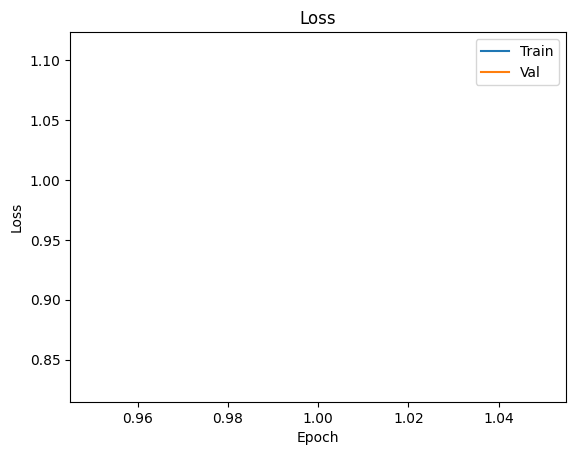

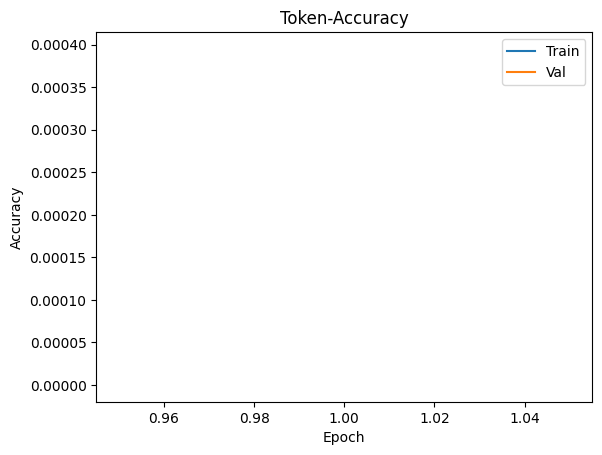


20 random examples:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia with a large os trigonum.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible gouty arthritis. 
Similarity: 0.3312


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, diagnosis pending, and recommended further investigation.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible gouty arthritis. 
Similarity: 0.3421


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient presents with right ankle osteoarthritis with bony erosion and multiple gout lesions, requiring further investigation and treatment.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting further investigation is needed. 
Similarity: 0.3555


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has probable gouty arthritis in both metatarsophalangeal joints.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible gouty arthritis. 
Similarity: 0.6977


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has advanced rheumatoid arthritis (RA) affecting both hands, feet, and the atlantoaxial joint with no instability, osteopenia, and no demonstrable instability.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible gouty arthritis. 
Similarity: 0.5172


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and degenerative changes.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting further investigation is needed. 
Similarity: 0.5565


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities found, resulting in no diagnosis and no recommendations.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible diagnosis of gout. 
Similarity: 0.2600


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : Mild degenerative change with a mild condition and recommendations for further evaluation.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting further investigation is needed. 
Similarity: 0.7298


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormalities were found, and no soft tissue abnormalities were observed.
Generated :  FINDINGS: The patient has a diagnosis of both first MTP joint osteoarthritis and gout arthritis. 
Similarity: 0.1759


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has osteoarthritis of the left calcaneal joint with spurs, and bony erosion in both wrists.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting further investigation is needed. 
Similarity: 0.3195


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has mild joint space narrowing in the right fifth metatarsophalangeal joint.
Generated :  FINDINGS: The patient has a diagnosis of both first MTP joint osteoarthritis and gout arthritis. 
Similarity: 0.4581


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, therefore no further action is needed.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting further investigation is needed. 
Similarity: 0.3225


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : A diffuse vascular calcification pattern suggests a degenerative change of the left foot.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion recommending further investigation. 
Similarity: 0.3379


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No further investigation is required due to the absence of additional findings.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting further investigation is needed. 
Similarity: 0.3118


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : No bony abnormality, diagnosis of no bony abnormality, recommend further evaluation.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible gouty arthritis. 
Similarity: 0.3212


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has soft tissue swelling in the left ankle and lower leg, along with osseous abnormalities in the lower femur and calcaneus.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible gouty arthritis. 
Similarity: 0.3437


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has a diagnosis of hallux vagus deformity and diffuse osteopenia.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible diagnosis of gout. 
Similarity: 0.3615


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has degenerative changes and fractures in both knees, including a calcaneous fracture, a fractured 5th metacarpal, and multiple fractures of the 3-4th metatarsals, suggestive of gout and degenerative changes due to old fractures.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting a possible diagnosis of gout. 
Similarity: 0.6081


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient has diffuse osteopenia and degenerative changes, requiring further management.
Generated :  FINDINGS: The patient has a degenerative change with a conclusion suggesting further investigation is needed. 
Similarity: 0.5625


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

————————————————————————————————————————
Clean     : The patient shows no significant change in their condition since the last study.
Generated :  FINDINGS: The patient has a diagnosis of both first MTP joint osteoarthritis and soft tissue swelling in the first MTP joint. 
Similarity: 0.2299


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-22 12:58:34,375 | INFO | 
Average semantic similarity over 240 test samples: 0.4015


In [10]:
import os
import json
import random
import logging
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import timm
import cv2
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# for semantic similarity
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# 1. Dataset & Collate
# ----------------------------
class FinalSamplesDataset(Dataset):
    def __init__(self, json_path, tokenizer, image_transform=None, patch_transform=None):
        self.tokenizer = tokenizer
        # Default image transform with mild geometric augmentations
        self.image_transform = image_transform or transforms.Compose([
            transforms.Resize((256, 256)),  # ensure compatibility with SwinV2 resolution
            transforms.RandomAffine(
                degrees=10,             # ±10°
                translate=(0.1, 0.1),   # ±10% translation
                scale=(0.95, 1.05)      # 0.95×–1.05× scaling
            ),
            transforms.ToTensor()
        ])
        # Default patch transform with the same mild augmentations
        self.patch_transform = patch_transform or transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.95, 1.05)
            ),
            transforms.ToTensor()
        ])
        with open(json_path, 'r') as f:
            raw = json.load(f)

        filtered = []
        for item in raw:
            merged = item.get('merged_image_path','')
            fps = item.get('file_paths',[])
            if isinstance(fps,str): fps=[fps]
            paths = [merged] + fps
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged,fps,item))

        self.data = {}
        for i,(merged,fps,item) in enumerate(filtered):
            self.data[i] = {
                'full': merged,
                'patches': fps,
                'keypoints': item.get('keypoints',{}),
                'clean': item.get('cleaned_report','')
            }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        # full image
        img = Image.open(e['full']).convert('RGB')
        img = self.image_transform(img)
        # patches
        patches = self._gen_patches(e['patches'], e['keypoints'])
        pt = [ self.patch_transform(Image.fromarray(p)) for p in patches ]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        # tokenize
        prompt = f"{self.tokenizer.bos_token} FINDINGS: {e['clean']} {self.tokenizer.eos_token}"
        tok = self.tokenizer(prompt, truncation=True, max_length=512, return_tensors='pt')
        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'input_ids':      input_ids,
            'attention_mask': attention_mask,
            'clean_text':     e['clean']
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200,300), patch_size=(112,112)):
        def extract(arr, side_kps):
            lst=[]; pts=side_kps[0]['keypoints']
            for i in range(17):
                x,y,s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s>0:
                    x0 = max(x-crop_size[0]//2,0)
                    y0 = max(y-crop_size[1]//2,0)
                    x1 = min(x+crop_size[0]//2,arr.shape[1])
                    y1 = min(y+crop_size[1]//2,arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size: lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1],patch_size[0],3),np.uint8)
            while len(lst)<17: lst.append(black)
            return lst[:17]

        left,right = [],[]
        if len(paths)==1:
            p=paths[0]
            if os.path.exists(p):
                arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                if kps_dict.get('left'):  left  = extract(arr,kps_dict['left'])
                if kps_dict.get('right'): right = extract(arr,kps_dict['right'])
        else:
            for side,p in zip(['left','right'],paths):
                if p and os.path.exists(p):
                    arr=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
                    if kps_dict.get(side):
                        lst=extract(arr,kps_dict[side])
                        (left if side=='left' else right).extend(lst)

        if left and not right: right=[cv2.flip(p,1) for p in left]
        if right and not left: left=[cv2.flip(p,1) for p in right]
        if not left and not right: return pad17([])+pad17([])
        return pad17(left)+pad17(right)

def collate_fn(batch):
    full_imgs = torch.stack([b['full_img'] for b in batch])
    patches   = torch.stack([b['patches']   for b in batch])
    ids       = [b['input_ids']      for b in batch]
    masks     = [b['attention_mask'] for b in batch]
    clean_txt = [b['clean_text']     for b in batch]

    input_ids      = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=0)
    attention_mask = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    return {
        'full_img':       full_imgs,
        'patches':        patches,
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'clean_text':     clean_txt
    }

# ----------------------------
# 2. Model
# ----------------------------
class VisionFusionEncoder(nn.Module):
    def __init__(self, vision_dim=768, num_heads=8):
        super().__init__()
        # ─── Swin V2 Base (dynamic window & resolution) ───
        self.global_enc = timm.create_model(
            'swinv2_base_window12to16_192to256',
            pretrained=True,
            num_classes=0
        )
        self.global_proj = nn.Linear(self.global_enc.num_features, vision_dim)
        # ───────────────────────────────────────────────

        res = models.resnet50(pretrained=True)
        res.fc = nn.Identity()
        self.patch_enc    = res
        self.patch_proj   = nn.Linear(2048, vision_dim)

        self.cross_attn1  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm1        = nn.LayerNorm(vision_dim)
        self.cross_attn2  = nn.MultiheadAttention(vision_dim, num_heads, batch_first=True)
        self.norm2        = nn.LayerNorm(vision_dim)

    def forward(self, full_img, patches):
        B = full_img.size(0)
        g = self.global_proj(self.global_enc(full_img))           # B×D
        P = patches.view(-1,3,112,112)
        p = self.patch_proj(self.patch_enc(P)).view(B,34,-1)      # B×34×D

        q1, _    = self.cross_attn1(g.unsqueeze(1), p, p)         # B×1×D
        fused1   = self.norm1(q1.squeeze(1) + g)                  # B×D
        q2, _    = self.cross_attn2(fused1.unsqueeze(1), p, p)    # B×1×D
        fused2   = self.norm2(q2.squeeze(1) + fused1)             # B×D

        return torch.cat([fused2.unsqueeze(1), p], dim=1)         # B×35×D

class MedicalReportGenerator(nn.Module):
    def __init__(self, tokenizer, vision_dim=768, gpt2_model='gpt2', device='cuda', sem_coef=0.1):
        super().__init__()
        self.device    = device
        self.tokenizer = tokenizer
        self.embedder  = SentenceTransformer('all-MiniLM-L6-v2')
        self.sem_coef  = sem_coef
        self.encoder   = VisionFusionEncoder(vision_dim)
        cfg = GPT2Config.from_pretrained(gpt2_model, add_cross_attention=True)
        self.decoder   = GPT2LMHeadModel.from_pretrained(gpt2_model, config=cfg)
        self.to(device)

    def forward(self, full_img, patches, input_ids, attention_mask, clean_texts, labels=None):
        # encode vision
        vt = self.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=self.device)
        # decode with cross-attention
        outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            labels=labels,
            return_dict=True
        )
        ce_loss = outputs.loss

        # semantic-aware loss
        with torch.no_grad():
            gen_ids = outputs.logits.argmax(-1)
            gen_texts = [ self.tokenizer.decode(g, skip_special_tokens=True) for g in gen_ids ]
            emb_gen   = self.embedder.encode(
                gen_texts,
                convert_to_tensor=True,
                device=self.device,
                show_progress_bar=False
            )
            emb_truth = self.embedder.encode(
                clean_texts,
                convert_to_tensor=True,
                device=self.device,
                show_progress_bar=False
            )
        sims      = util.cos_sim(emb_gen, emb_truth)  # (batch, batch)
        sem_loss  = torch.mean(1.0 - sims.diag())

        loss = ce_loss + self.sem_coef * sem_loss
        return loss, outputs.logits

# ----------------------------
# 3. Training & Eval
# ----------------------------
def train_epoch(model, loader, optim, scheduler=None, epoch=0):
    model.train()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        optim.zero_grad()
        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        loss.backward()
        optim.step()
        if scheduler: scheduler.step()

        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

@torch.no_grad()
def eval_epoch(model, loader, epoch=0):
    model.eval()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    loop = tqdm(loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
    for batch in loop:
        full    = batch['full_img'].to(model.device)
        patches = batch['patches'].to(model.device)
        ids     = batch['input_ids'].to(model.device)
        mask    = batch['attention_mask'].to(model.device)
        clean   = batch['clean_text']

        loss, logits = model(full, patches, ids, mask, clean, labels=ids)
        preds = logits.argmax(-1)
        acc = (preds == ids).masked_select(mask.bool()).float().mean().item()

        bsz = ids.size(0)
        tot_loss += loss.item() * bsz
        tot_acc  += acc * bsz
        n       += bsz
        loop.set_postfix(loss=loss.item(), acc=acc)

    return tot_loss / n, tot_acc / n

# ----------------------------
# 4. Plotting
# ----------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(); plt.plot(epochs, train_losses);   plt.plot(epochs, val_losses)
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.show()
    plt.figure(); plt.plot(epochs, train_accs);   plt.plot(epochs, val_accs)
    plt.title('Token-Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(['Train','Val']); plt.show()

# ----------------------------
# 5. Main
# ----------------------------
def main():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s | %(levelname)s | %(message)s',
        handlers=[
            logging.FileHandler("training.log"),
            logging.StreamHandler()
        ]
    )
    JSON_PATH = './final_samples_both_only_v2_cleaned.json'
    DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH, EPOCHS, LR = 8, 1, 5e-5

    # tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    tokenizer.bos_token = tokenizer.eos_token

    # data & splits
    ds = FinalSamplesDataset(JSON_PATH, tokenizer)
    idxs = list(range(len(ds)))
    tr, tmp = train_test_split(idxs, test_size=0.2, random_state=42)
    va, te  = train_test_split(tmp, test_size=0.5, random_state=42)

    train_loader = DataLoader(torch.utils.data.Subset(ds, tr),
                              batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(torch.utils.data.Subset(ds, va),
                              batch_size=BATCH, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(torch.utils.data.Subset(ds, te),
                              batch_size=1, shuffle=False, collate_fn=collate_fn)

    # model & optimizer
    model = MedicalReportGenerator(tokenizer, device=DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # train & validate
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for ep in range(1, EPOCHS + 1):
        tr_l, tr_a = train_epoch(model, train_loader, optimizer, epoch=ep)
        va_l, va_a = eval_epoch(model, val_loader, epoch=ep)
        print(f"Epoch {ep:02d} → train_loss={tr_l:.4f}, val_loss={va_l:.4f}, train_acc={tr_a:.4f}, val_acc={va_a:.4f}")
        train_losses.append(tr_l)
        val_losses.append(va_l)
        train_accs.append(tr_a)
        val_accs.append(va_a)

    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # ----------------------------
    # 6. Test: sampling + overall similarity
    # ----------------------------
    model.eval()

    print("\n20 random examples:")
    examples = random.sample(range(len(te)), 20)
    for idx in examples:
        batch = next(iter(DataLoader([ds[te[idx]]], batch_size=1, collate_fn=collate_fn)))
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=0.1,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)

        emb = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sim = util.cos_sim(emb[0], emb[1]).item()

        print("—" * 40)
        print("Clean     :", clean_txt)
        print("Generated :", gen)
        print(f"Similarity: {sim:.4f}")

    # overall average
    sims = []
    for batch in tqdm(test_loader, desc="Evaluating test set", disable=True):
        full_img  = batch['full_img'].to(DEVICE)
        patches   = batch['patches'].to(DEVICE)
        clean_txt = batch['clean_text'][0]

        vt = model.encoder(full_img, patches)
        vm = torch.ones(vt.size()[:2], device=DEVICE)

        prefix = tokenizer(f"{tokenizer.bos_token} FINDINGS:", return_tensors='pt').to(DEVICE)
        out = model.decoder.generate(
            **prefix,
            max_length=128,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=0.1,
            num_return_sequences=1,
            encoder_hidden_states=vt,
            encoder_attention_mask=vm,
            use_cache=True
        )
        gen = tokenizer.decode(out[0], skip_special_tokens=True)
        emb_pair = model.embedder.encode([gen, clean_txt], convert_to_tensor=True, device=DEVICE)
        sims.append(util.cos_sim(emb_pair[0], emb_pair[1]).item())

    overall = float(np.mean(sims))
    logging.info(f"\nAverage semantic similarity over {len(sims)} test samples: {overall:.4f}")

if __name__ == '__main__':
    main()
